### Predicting Customer Card Consumption Trend

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error,mean_absolute_percentage_error,mean_squared_error
from sklearn.feature_selection import RFE, f_regression,SelectKBest
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
import os
# from pandas_profiling import ProfileReport

%matplotlib inline

In [ ]:
# Got to working directory
# os.chdir('/Users/BackUp/AnalytixLabs/MachineLearning_TextMining/Assignmnts/11. Capstone Case Study - Predict Cred Card Consumption')
# os.listdir()

### Import Dataset and EDA

In [4]:
cust_beh = pd.read_excel('CustomerBehaviorData.xlsx')
cust_beh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     20000 non-null  int64  
 1   cc_cons_apr            20000 non-null  float64
 2   dc_cons_apr            20000 non-null  float64
 3   cc_cons_may            19999 non-null  float64
 4   dc_cons_may            20000 non-null  float64
 5   cc_cons_jun            20000 non-null  float64
 6   dc_cons_jun            19999 non-null  float64
 7   cc_count_apr           19999 non-null  float64
 8   cc_count_may           20000 non-null  int64  
 9   cc_count_jun           20000 non-null  int64  
 10  dc_count_apr           20000 non-null  int64  
 11  dc_count_may           20000 non-null  int64  
 12  dc_count_jun           20000 non-null  int64  
 13  card_lim               20000 non-null  int64  
 14  personal_loan_active   20000 non-null  int64  
 15  ve

In [5]:
cust_demog = pd.read_excel('CustomerDemographics.xlsx')
cust_demog.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            20000 non-null  int64  
 1   account_type                  19999 non-null  object 
 2   gender                        19999 non-null  object 
 3   age                           20000 non-null  int64  
 4   Income                        19999 non-null  object 
 5   Emp_Tenure_Years              20000 non-null  float64
 6   Tenure_with_Bank              20000 non-null  int64  
 7   region_code                   19999 non-null  float64
 8   NetBanking_Flag               20000 non-null  int64  
 9   Avg_days_between_transaction  19997 non-null  float64
dtypes: float64(3), int64(4), object(3)
memory usage: 1.5+ MB


If any of the discrete (categorical) variables is given in 'int' dtype, then that is done to save storage. If we convert that variable back to object type then we loose advantage of savings in storage. Therefore, in that scenario it is best to convert the variable into 'categorical' dtype which treats the variable as discrete while keeping it in the int dtype. 

In [6]:
# as per data dictionary, region_code and NetBanking_Flag should be object/ categorical type
cust_demog.region_code = cust_demog.region_code.astype('object')
cust_demog.NetBanking_Flag = cust_demog.NetBanking_Flag.astype('category')
cust_demog.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   ID                            20000 non-null  int64   
 1   account_type                  19999 non-null  object  
 2   gender                        19999 non-null  object  
 3   age                           20000 non-null  int64   
 4   Income                        19999 non-null  object  
 5   Emp_Tenure_Years              20000 non-null  float64 
 6   Tenure_with_Bank              20000 non-null  int64   
 7   region_code                   19999 non-null  object  
 8   NetBanking_Flag               20000 non-null  category
 9   Avg_days_between_transaction  19997 non-null  float64 
dtypes: category(1), float64(2), int64(3), object(4)
memory usage: 1.4+ MB


In [7]:
cc_cons = pd.read_excel('CreditConsumptionData.xlsx')
cc_cons.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   ID       20000 non-null  int64  
 1   cc_cons  15000 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 312.6 KB


### Merge the datasets, setting ID as index

In [8]:
data = pd.merge(cust_beh, cust_demog, on = 'ID')
data = data.merge(cc_cons, on = 'ID')
data.set_index('ID', inplace = True)
data.shape
# data.to_excel('data.xlsx')

(20000, 48)

### Creating profile report using pandas profiling feature - Basic EDA

In [9]:
# Creation of Profiling report is making the kernel dead. So not using it as of now. 

# report = ProfileReport(data)
# report

In [10]:
# separating main and target data
main = data.loc[data.cc_cons.notna(), ]
target = data.loc[data.cc_cons.isna(), ]
print('Main', main.shape, '|', 'Target', target.shape)

Main (15000, 48) | Target (5000, 48)


In [11]:
# function for EDA 
def eda(col):
    
    n = col.shape[0]
    nmiss = col.isna().sum()
    perc_miss = ( nmiss / n ) * 100
    
    q1 = col.quantile(0.25)
    q3 = col.quantile(0.75)
    iqr = q3 - q1
    u_cutoff = q3 + (1.5 * iqr)
    l_cutoff = q1 - (1.5 * iqr)
    
    return pd.Series([n, nmiss, perc_miss, col.mean(), col.std(), col.var(), col.min(), l_cutoff, col.quantile(0.01), 
                      col.quantile(0.05),col.quantile(0.1), col.quantile(0.25), col.quantile(0.5), col.quantile(0.75),
                      col.quantile(0.95), col.quantile(0.99), col.max(), u_cutoff], 
                    index = ['Total', 'TotalMissing', 'PercMissing', 'Mean', 'Std', 'Var', 'Min', 'Lower_CutOff-IQR',
                             'P1', 'P5', 'P10','P25','P50','P75','P95','P99','Max','Upper_CutOff-IQR'])

In [12]:
# to display all the columns of the dataframe
pd.set_option('display.max_columns', None)

In [13]:
# EDA for numerical variables
# main.select_dtypes(['int', 'float']).apply(eda).to_excel('main_num_eda.xlsx')
main.select_dtypes(['int', 'float']).apply(eda)

,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,cc_count_jun,dc_count_apr,dc_count_may,dc_count_jun,card_lim,personal_loan_active,vehicle_loan_active,personal_loan_closed,vehicle_loan_closed,investment_1,investment_2,investment_3,investment_4,debit_amount_apr,credit_amount_apr,debit_count_apr,credit_count_apr,max_credit_amount_apr,debit_amount_may,credit_amount_may,credit_count_may,debit_count_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,emi_active,age,Emp_Tenure_Years,Tenure_with_Bank,Avg_days_between_transaction,cc_cons
Total,1.500000e+04,1.500000e+04,1.500000e+04,1.500000e+04,1.500000e+04,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,1.500000e+04,15000.0,15000.0,15000.000000,15000.0,1.500000e+04,1.500000e+04,1.500000e+04,1.500000e+04,1.500000e+04,1.500000e+04,15000.000000,15000.000000,1.500000e+04,1.500000e+04,1.500000e+04,15000.000000,15000.000000,1.500000e+04,1.500000e+04,1.500000e+04,15000.000000,15000.000000,1.500000e+04,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,1.500000e+04
TotalMissing,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.0,1.000000,0.0,0.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,1.000000e+00,0.000000,0.000000,0.000000,1.000000,0.000000e+00
PercMissing,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.006667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.0,0.006667,0.0,0.000000e+00,0.000000e+00,1.333333e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.006667,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,6.666667e-03,0.000000,0.000000,0.000000,0.006667,0.000000e+00
Mean,1.795739e+04,8.171098e+03,1.633705e+04,7.703605e+03,1.212901e+04,7.097395e+03,41.489499,33.490200,41.507000,17.171000,13.979733,30.287267,2.770051e+05,1.0,1.0,1.000000,1.0,6.194140e+05,2.333642e+05,4.444094e+04,3.523049e+03,6.823421e+04,8.079761e+04,36.402227,11.291400,5.438954e+04,6.554492e+04,8.356935e+04,11.923133,40.996867,5.718791e+04,7.615987e+04,7.850316e+04,19.946400,44.647867,5.258654e+04,1.576139e+04,47.790600,15.184007,5.510000,11.049603,5.515773e+04
Std,2.518794e+04,1.477303e+04,2.706085e+04,1.898730e+04,1.848878e+04,1.325170e+04,97.435394,49.540999,47.342918,19.359678,17.087203,29.252490,1.794295e+05,0.0,0.0,0.000000,0.0,3.087815e+06,4.073237e+05,8.811793e+04,7.373355e+03,1.126786e+05,1.989060e+05,30.701081,12.670785,1.950943e+05,1.016829e+05,1.776300e+05,16.843563,40.537354,2.000194e+05,1.545112e+05,1.482005e+05,27.200165,35.089082,1.282601e+05,1.179191e+05,30.632766,20.312648,2.865783,5.492379,9.767097e+04
Var,6.344323e+08,2.182424e+08,7.322896e+08,3.605174e+08,3.418350e+08,1.756074e+08,9493.656094,2454.310591,2241.351908,374.797145,291.972521,855.708192,3.219496e+10,0.0,0.0,0.000000,0.0,9.534600e+12,1.659126e+11,7.764770e+09,5.436637e+07,1.269647e+10,3.956359e+10,942.556365,160.548789,3.806177e+10,1.033940e+10,3.155243e+10,283.705605,1643.277075,4.000774e+10,2.387371e+10,2.196337e+10,739.848984,1231.243685,1.645065e+10,1.390492e+10,938.366376,412.603682,8.212714,30.166229,9.539619e+09
Min,2.530000e+02,1.935000e+01,1.570000e+02,2.200000e+01,6.500000e+01,6.200000e+01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000e+00,1.0,1.0,1.000000,1.0,3.000000e-01,3.000000e+00,4.620000e+02,-1.217900e+04,4.010000e+00,6.138000e+01,0.000000,0.000000,1.000000e+00,2.820000e+01,1.061000e+01,0.000000,0.000000,2.500000e-01,5.230000e+00,1.188000e+01,1.000000,0.000000,6.000000e-02,0.000000e+00,25.000000,0.500000,1.000000,2.000000,0.000000e+00


In [14]:
# post EDA - age and Emp_Tenure_Years are having abnormal values. Replacing the abnormal values with the mean of 
# age values below 100
main.age.unique()

array([ 30,  37,  33,  63,  58,  34,  47,  29,  44,  36,  32,  27,  28,
        53,  46,  62,  40,  35,  42,  55,  60,  66,  56, 223, 118,  25,
        51,  31,  38,  39, 220,  69, 120,  67,  64, 219, 222,  50,  54,
        49,  61, 221,  65])

In [15]:
mean_age = round(main.loc[main.age < 100, 'age'].mean(), 0)
main.age = np.where(main.age >= 100, mean_age, main.age)
main.age.unique()

/Users/shamshersingh/opt/anaconda3/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


array([30., 37., 33., 63., 58., 34., 47., 29., 44., 36., 32., 27., 28.,
       53., 46., 62., 40., 35., 42., 55., 60., 66., 56., 43., 25., 51.,
       31., 38., 39., 69., 67., 64., 50., 54., 49., 61., 65.])

In [16]:
main.Emp_Tenure_Years.unique()

array([  7. ,  10.2,   3.9,  25.8,   6.5,  15.2,   2.8,  27. ,  21.6,
         2.7,  11.2,   2.4,  10.8,   0.7,   5.6,  33. ,  26. ,  10. ,
        16.8,   6.8,   2. ,   1. ,   9.6,  10.4,   3. ,  22. ,  28. ,
        17.6,   4. ,  13.8,  12. ,   2.1,  13.2,   3.5,   4.6,   1.3,
         6.6,  40. ,   8. ,  20. ,  20.8,  14.4,  27.6,   7.5, 121.8,
         4.5,  24. ,   2.6,   3.2,  98. ,  11.7,   3.6,   9.2,  11.9,
        46. ,  32. ,  23. ,   4.2,  29.7,  23.1,   6. ,   5.1,   0.8,
         7.8,   6.2,   1.1,  14. ,   9. ,  19.2,   5. ,   5.7,   5.2,
        12.9,  16. ,   8.1,  60. ,  10.5,   4.8,   6.4,  17. ,   7.2,
        16.5,  12.6,   8.5,   4.9,  18.9,  13. ,  80. ,  11. ,   1.5,
         6.3,   3.3,  19.8,   8.8,   1.2,  47. ,  15.4,  24.5,  36. ,
         2.2,   9.1,  44. ,  24.3, 159.2,   9.8,  13.5,  15. ,  39.6,
         1.7,  20.2,   7.6,  15.3,  18. ,   5.4,   3.1,  26.4,  78.4,
        32.2,   0.9,   1.9,  21. ,   1.6,  34.2,  12.8, 119.4,  25.2,
        38. ,  39.2,

### Cutting off the Emp_Tenure_Years to 37.5 as upper IQR cut-off range

In [17]:
main.Emp_Tenure_Years = np.where(main.Emp_Tenure_Years >= 40, 37.5,main.Emp_Tenure_Years)
main.Emp_Tenure_Years.unique()

array([ 7. , 10.2,  3.9, 25.8,  6.5, 15.2,  2.8, 27. , 21.6,  2.7, 11.2,
        2.4, 10.8,  0.7,  5.6, 33. , 26. , 10. , 16.8,  6.8,  2. ,  1. ,
        9.6, 10.4,  3. , 22. , 28. , 17.6,  4. , 13.8, 12. ,  2.1, 13.2,
        3.5,  4.6,  1.3,  6.6, 37.5,  8. , 20. , 20.8, 14.4, 27.6,  7.5,
        4.5, 24. ,  2.6,  3.2, 11.7,  3.6,  9.2, 11.9, 32. , 23. ,  4.2,
       29.7, 23.1,  6. ,  5.1,  0.8,  7.8,  6.2,  1.1, 14. ,  9. , 19.2,
        5. ,  5.7,  5.2, 12.9, 16. ,  8.1, 10.5,  4.8,  6.4, 17. ,  7.2,
       16.5, 12.6,  8.5,  4.9, 18.9, 13. , 11. ,  1.5,  6.3,  3.3, 19.8,
        8.8,  1.2, 15.4, 24.5, 36. ,  2.2,  9.1, 24.3,  9.8, 13.5, 15. ,
       39.6,  1.7, 20.2,  7.6, 15.3, 18. ,  5.4,  3.1, 26.4, 32.2,  0.9,
        1.9, 21. ,  1.6, 34.2, 12.8, 25.2, 38. , 39.2, 36.8, 15.6, 30.6,
       11.6, 17.4,  8.4,  4.4, 13.3, 27.9, 15.5,  1.4,  8.7,  8.2, 29.4,
        9.9, 33.6,  8.6, 20.5, 18.4, 16.2, 28.7, 13.6, 14.1, 20.3,  9.4,
       28.2,  4.3, 31.5, 30.8, 14.5, 23.4, 21.7, 19

In [18]:
# Post further analysis, 'personal_loan_active', 'vehicle_loan_active', 'personal_loan_closed' and 'vehicle_loan_closed'
# have zero variance. Therefore these variables will have no significance in the model. Dropping these variables
main.drop(columns = ['personal_loan_active', 'vehicle_loan_active', 'personal_loan_closed','vehicle_loan_closed'], axis = 1, 
         inplace = True)
main.shape

/Users/shamshersingh/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


(15000, 44)

In [19]:
# now grouping the age into 5 categories and converting the age_gps to categorical variable
main['age_gps'] = pd.cut(main.age, 5, retbins = False, labels = False)
main.drop('age', axis = 1, inplace = True)
main.age_gps = main.age_gps.astype('category')
main.head()

/var/folders/vt/5tvfbhvx4g74ydhsmm2p5bmw0000gn/T/ipykernel_9305/542957651.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main['age_gps'] = pd.cut(main.age, 5, retbins = False, labels = False)


,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,cc_count_jun,dc_count_apr,dc_count_may,dc_count_jun,card_lim,investment_1,investment_2,investment_3,investment_4,debit_amount_apr,credit_amount_apr,debit_count_apr,credit_count_apr,max_credit_amount_apr,debit_amount_may,credit_amount_may,credit_count_may,debit_count_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,loan_enq,emi_active,account_type,gender,Income,Emp_Tenure_Years,Tenure_with_Bank,region_code,NetBanking_Flag,Avg_days_between_transaction,cc_cons,age_gps
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
17051,3412.60,2909.34,1077.36,3084.50,4615.97,6693.0,19.0,10,2,53,1,42,358000,331.2,130000.00,300500.0,12174.0,25210.23,27532.37,103.0,36,28579.0,44974.63,42852.00,1,108,97916.0,45253.64,47635.00,2,18,19947.0,Y,3448.84,current,M,MEDIUM,7.0,5,956.0,1,20.0,13434.0,0
11491,18133.76,3877.00,6123.78,5597.43,64620.00,6117.0,4.0,60,1,4,1,17,114000,5809950.0,3.00,610000.0,2351.0,30937.00,50784.00,40.0,35,25379.0,117575.67,24257.00,1,4,25125.0,12912.33,18369.00,3,49,20585.0,Y,3812.69,current,M,LOW,10.2,8,966.0,1,5.0,449.0,1
7433,6363.65,735.49,8799.00,13768.00,38266.00,2638.0,2.0,83,47,4,62,42,360000,27324.0,176487.60,2156.0,3735.0,12940.25,26345.00,11.0,3,19224.0,14646.35,38306.00,70,11,38546.0,93567.51,26713.00,47,49,13950.0,Y,9432.90,current,M,MEDIUM,3.9,3,505.0,1,15.0,11968.0,0
14606,12765.66,4429.16,16745.86,6360.00,29063.97,3711.0,12.0,2,16,24,12,58,155000,370776.0,63000.00,26241.0,0.0,78122.15,49660.00,42.0,26,72186.0,14719.00,46132.05,43,1,180315.0,176394.48,35062.74,3,37,37018.0,Y,144.61,current,M,LOW,25.8,6,631.0,0,15.0,32029.0,4
8381,27819.70,1944.00,7006.50,2228.50,1096.25,1065.0,15.0,13,61,7,5,80,362000,10006.2,7216.53,13873.0,-4679.0,6855.71,933699.00,46.0,35,18867.0,189938.76,37191.00,2,14,13480.0,3167.00,19056.00,2,15,24274.0,Y,1887.89,saving,M,MEDIUM,6.5,7,698.0,0,9.0,16394.0,0


### Performing similar tasks for target data

In [20]:
target.select_dtypes(['int', 'float']).apply(eda)

,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,cc_count_jun,dc_count_apr,dc_count_may,dc_count_jun,card_lim,personal_loan_active,vehicle_loan_active,personal_loan_closed,vehicle_loan_closed,investment_1,investment_2,investment_3,investment_4,debit_amount_apr,credit_amount_apr,debit_count_apr,credit_count_apr,max_credit_amount_apr,debit_amount_may,credit_amount_may,credit_count_may,debit_count_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,emi_active,age,Emp_Tenure_Years,Tenure_with_Bank,Avg_days_between_transaction,cc_cons
Total,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5.000000e+03,5000.0,5000.0,5000.0,5000.0,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5000.000000,5000.000000,5.000000e+03,5.000000e+03,5.000000e+03,5000.000000,5000.000000,5.000000e+03,5.000000e+03,5.000000e+03,5000.000000,5000.000000,5.000000e+03,5.000000e+03,5000.000000,5000.000000,5000.000000,5000.000000,5000.0
TotalMissing,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,2.000000,5000.0
PercMissing,0.000000e+00,0.000000e+00,2.000000e-02,0.000000e+00,0.000000e+00,2.000000e-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.040000,100.0
Mean,1.755579e+04,8.008519e+03,1.574221e+04,7.698893e+03,1.215619e+04,7.146655e+03,41.978000,33.805800,41.359800,16.773800,14.331800,31.062800,2.823701e+05,1.0,1.0,1.0,1.0,5.053503e+05,2.317157e+05,4.509972e+04,3.412613e+03,6.987735e+04,7.635454e+04,35.754800,11.128800,5.450713e+04,6.459067e+04,8.104022e+04,11.906600,40.908800,6.126822e+04,8.401159e+04,7.975822e+04,19.782600,44.172800,5.363976e+04,1.431139e+04,47.317400,15.316980,5.454200,11.030212,NaN
Std,2.507159e+04,1.395306e+04,2.478390e+04,1.411010e+04,1.967165e+04,1.350024e+04,99.034860,52.580440,45.242857,19.059331,17.366912,29.565326,1.846470e+05,0.0,0.0,0.0,0.0,2.429148e+06,4.081473e+05,8.966297e+04,7.358082e+03,1.171108e+05,1.256308e+05,30.188470,12.614184,2.003230e+05,1.017427e+05,1.515226e+05,16.893980,40.636648,2.324130e+05,4.101948e+05,1.808167e+05,26.618382,35.055646,1.510505e+05,1.270072e+05,29.525809,20.981475,2.884296,5.445427,NaN
Var,6.285847e+08,1.946878e+08,6.142419e+08,1.990950e+08,3.869739e+08,1.822565e+08,9807.903497,2764.702627,2046.916127,363.258085,301.609631,874.108478,3.409452e+10,0.0,0.0,0.0,0.0,5.900761e+12,1.665842e+11,8.039449e+09,5.414137e+07,1.371494e+10,1.578310e+10,911.343746,159.117634,4.012931e+10,1.035158e+10,2.295910e+10,285.406558,1651.337150,5.401582e+10,1.682598e+11,3.269468e+10,708.538245,1228.898320,2.281625e+10,1.613084e+10,871.773412,440.222274,8.319166,29.652679,NaN
Min,2.940000e+02,4.100000e+01,1.570000e+02,2.200000e+01,7.500000e+01,6.200000e+01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000e+00,1.0,1.0,1.0,1.0,3.000000e-01,3.000000e+00,4.620000e+02,-1.217900e+04,7.000000e+00,1.114400e+02,0.000000,0.000000,1.880000e+00,8.975000e+01,6.977000e+01,0.000000,0.000000,2.500000e-01,4.900000e+01,1.188000e+01,1.000000,0.000000,6.000000e-02,0.000000e+00,25.000000,0.500000,1.000000,2.000000,NaN
Lower_CutOff-IQR,-2.026505e+04,-1.012265e+04,-1.773831e+04,-8.633000e+03,-1.365393e+04,-7.255750e+03,-53.50000

In [21]:
# replacing abnormal age values with the mean of age values below 100
mean_age = round(target.loc[(target.age < 100), 'age'].mean(),1)
target.age = np.where(target.age >= 100, mean_age, target.age )
target.age.unique()

/Users/shamshersingh/opt/anaconda3/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


array([37. , 33. , 53. , 62. , 30. , 42.5, 34. , 29. , 35. , 60. , 38. ,
       47. , 40. , 42. , 49. , 58. , 55. , 27. , 31. , 36. , 56. , 28. ,
       46. , 32. , 66. , 39. , 51. , 63. , 44. , 69. , 50. , 67. , 64. ,
       25. , 61. , 65. , 54. ])

In [22]:
# replacing abnormal values of Emp_Tenure_Years
target.Emp_Tenure_Years = np.where(target.Emp_Tenure_Years >= 40, 37.5,target.Emp_Tenure_Years)
target.Emp_Tenure_Years.unique()

array([11.9,  7.8, 33. , 12.6,  8. ,  9.1, 37.5, 11.2,  2.6,  8.1, 13.5,
       16. ,  1.8, 21.6, 26.4,  4. ,  9. ,  6. , 10.2, 19.8, 15.3, 11. ,
        5.8,  5.6,  5.2, 18. , 10.8, 29.4, 15.2, 17.5,  2.7,  6.5, 16.5,
        0.7,  1.3, 12. , 13.2, 30.4,  6.6,  6.4, 28.8,  7.2, 15.4,  3.3,
        4.8,  5. ,  7. , 17. ,  5.1, 18.9,  2.2, 20. , 19. , 10.5, 24. ,
        8.4, 11.7, 23.4, 16.2,  2.8,  3.6,  9.9, 25.2, 24.5,  4.4,  9.8,
       35. , 33.6,  4.5,  3. ,  0.8,  6.3,  5.4, 10. ,  5.5,  3.2,  2.4,
       13.3, 29.7,  1.4, 21.7, 38.7,  3.4,  1.5,  1.7, 14. , 32.2, 21. ,
        9.6, 34.3,  4.3,  2.1, 10.4,  3.9, 15. , 37.6, 22.8,  6.8, 13.6,
       14.4, 39.6, 27. ,  2. , 16.8, 36.8, 28. , 17.6,  7.5, 13. , 17.4,
       26. ,  3.5,  8.5,  1.2, 24.3,  1. , 32. ,  4.6, 23. ,  9.2, 22. ,
       38. ,  3.8, 35.2, 20.8, 26.6, 32.4,  8.2, 15.5, 21.5, 27.9, 30. ,
       27.6, 11.6, 19.2, 18.2,  4.2, 37.8, 29. , 30.1,  2.5,  7.6, 32.8,
        4.7, 36. ,  0.9, 36.9, 18.4, 30.8,  1.1,  4

In [23]:
# Dropping 'personal_loan_active', 'vehicle_loan_active', 'personal_loan_closed' and 'vehicle_loan_closed'

target.drop(columns = ['personal_loan_active', 'vehicle_loan_active', 'personal_loan_closed','vehicle_loan_closed'], axis = 1, 
         inplace = True)
target.shape

/Users/shamshersingh/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


(5000, 44)

In [24]:
# now grouping the age into 5 categories and converting the age_gps to categorical variable
target['age_gps'] = pd.cut(target.age, 5, retbins = False, labels = False)
target.drop('age', axis = 1, inplace = True)
target.age_gps = target.age_gps.astype('category')
target.head()

/var/folders/vt/5tvfbhvx4g74ydhsmm2p5bmw0000gn/T/ipykernel_9305/2609281312.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target['age_gps'] = pd.cut(target.age, 5, retbins = False, labels = False)


,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,cc_count_jun,dc_count_apr,dc_count_may,dc_count_jun,card_lim,investment_1,investment_2,investment_3,investment_4,debit_amount_apr,credit_amount_apr,debit_count_apr,credit_count_apr,max_credit_amount_apr,debit_amount_may,credit_amount_may,credit_count_may,debit_count_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,loan_enq,emi_active,account_type,gender,Income,Emp_Tenure_Years,Tenure_with_Bank,region_code,NetBanking_Flag,Avg_days_between_transaction,cc_cons,age_gps
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
17591,2795.45,1290.0,6141.05,676.50,9146.10,15479.00,4.0,10,4,47,56,6,125000,13.80,376600.50,1633.0,-5715.49023,27646.84,44341.00,16.0,36,24485.0,23512.67,41755.0,24,20,9750.0,30527.88,31271.00,3,12,25945.92,Y,1170.49,current,M,MEDIUM,11.9,4,575.0,1,16.0,NaN,1
13541,29405.13,1640.0,1670.00,2463.92,10947.50,956.00,3.0,10,4,50,38,31,59000,101891.25,470000.00,891.0,35346.00000,32247.25,21946.00,42.0,5,3375.0,15049.44,130299.0,43,40,16967.0,14342.83,16582.00,6,39,12214.00,Y,16447.45,current,M,MEDIUM,7.8,6,394.0,0,19.0,NaN,0
13431,5985.20,6189.0,2696.09,766.00,716.00,4133.22,7.0,30,5,24,27,2,49999,53374.97,674291.83,54101.0,2557.00000,63169.00,36616.50,41.0,6,14950.0,133659.00,40422.0,42,35,36398.0,32503.16,33539.54,5,9,13215.00,Y,2622.28,current,M,LOW,33.0,10,324.0,1,15.0,NaN,3
8687,2105.93,18225.0,34763.56,167.00,4260.27,20185.00,1.0,99,71,5,1,11,520000,9118.35,470000.00,5905.0,5464.00000,39442.80,43173.38,46.0,1,235844.0,99686.03,48148.0,3,5,97825.0,93572.42,109429.75,21,0,72317.00,Y,340.79,current,M,MEDIUM,7.8,5,370.0,1,7.0,NaN,0
14727,3269.00,3532.0,3158.40,2699.77,3373.48,5120.00,2.0,10,47,5,25,1,152000,12850544.36,101.24,130000.0,1332.00000,8937.00,15232.00,11.0,1,14495.0,190374.25,25926.0,70,75,27936.0,19011.50,41401.00,6,35,42344.00,Y,2812.20,current,M,LOW,12.6,9,505.0,1,3.0,NaN,4


In [25]:
# EDA for categorical/ object type variables
def eda_cat(col):
    
    n = col.shape[0]
    nmiss = col.isna().sum()
    perc_miss = ( nmiss / n ) * 100
    
    mode = col.value_counts().sort_values(ascending = False).reset_index()
    return pd.Series([col.count(), col.nunique(), col.isnull().sum(), mode.iloc[0,0], mode.iloc[0, 1], 
                          round(mode.iloc[0, 1] * 100 / col.count(), 2)], 
                     
                  index = ['N', 'CARDINALITY', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])

In [26]:
main.select_dtypes(['object', 'category']).apply(eda_cat)

,loan_enq,account_type,gender,Income,region_code,NetBanking_Flag,age_gps
N,14998,15000,15000,15000,15000.00,15000.00,15000.00
CARDINALITY,1,2,2,3,210.00,2.00,5.00
NMISS,2,0,0,0,0.00,0.00,0.00
MODE,Y,current,M,MEDIUM,249.00,1.00,0.00
FREQ,14998,12727,12945,9612,395.00,10793.00,4631.00
PERCENT,100.0,84.85,86.3,64.08,2.63,71.95,30.87


In [27]:
# from the summary above, loan_enq has 2 missing values and balance values are Y. Therefore this variable is 
# not useful for the model as it has zero variance
main.drop(columns = ['loan_enq'], axis = 1, inplace = True)
main.shape

/Users/shamshersingh/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


(15000, 43)

Further analysis reveals that the data is highly skewed towards Male and current account type.

In [28]:
# Further, since the cardinality of region variable is very high, therefore we need to group this variable into different
# categories. We will group the data as per credit card consumption
gpd_data = main[['region_code', 'cc_cons']]
gpd_data = gpd_data.groupby('region_code')

# get the count of each region_code
Count = gpd_data.apply(lambda x : len(x))
print(Count, '\n')

# get the median value of cc_cons for each region_code
Median_cc_cons = gpd_data.apply(lambda x : x.cc_cons.median())

# when we group the data, the data is consolidated as a dictionary. The keys are the column which is used for 
# groupedby and columns which are grouped upon are consolidated as sub-dataframe which is stored as value for 
# each key

# column 0 in gpd_data dataframe is the variable which is groupedby and columns 1 is a sub-dataframe which are grouped
# upon. In this case, columns 0 is the region_code and columns 1 is the subdataframe with cc_cons values. Dropping 
# column 1 since it is no more required
gpd_data = pd.DataFrame(gpd_data)
gpd_data.to_excel('gpd_data.xlsx')
gpd_data.drop(columns = 1, axis = 1, inplace = True)

# adding median values
gpd_data['Median_cc_cons'] = Median_cc_cons.values
gpd_data.rename({0:'region_code'}, axis = 1, inplace = True)

# now grouping the region_code based on the median of cc_cons
gpd_data = gpd_data.sort_values(by = 'Median_cc_cons')
gpd_data['Region_Code_Gp'] = pd.cut(gpd_data.Median_cc_cons, 5, retbins = False, labels = False)
print(gpd_data.Region_Code_Gp.value_counts(), '\n')

# join this data with the main one 
to_join = gpd_data[['region_code', 'Region_Code_Gp']].set_index('region_code')
main = main.join(to_join, on = 'region_code')
main.Region_Code_Gp = main.Region_Code_Gp.astype('category')
main.drop('region_code', axis = 1, inplace = True)
print(main.shape)
main.head(10)

region_code
123.0     96
233.0    158
243.0     79
244.0     77
245.0    122
        ... 
966.0    167
968.0     40
969.0     65
970.0      2
974.0     61
Length: 210, dtype: int64 

0    208
3      1
4      1
Name: Region_Code_Gp, dtype: int64 

(15000, 43)


,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,cc_count_jun,dc_count_apr,dc_count_may,dc_count_jun,card_lim,investment_1,investment_2,investment_3,investment_4,debit_amount_apr,credit_amount_apr,debit_count_apr,credit_count_apr,max_credit_amount_apr,debit_amount_may,credit_amount_may,credit_count_may,debit_count_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,emi_active,account_type,gender,Income,Emp_Tenure_Years,Tenure_with_Bank,NetBanking_Flag,Avg_days_between_transaction,cc_cons,age_gps,Region_Code_Gp
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
17051,3412.60,2909.34,1077.36,3084.50,4615.97,6693.00,19.0,10,2,53,1,42,358000,331.20,130000.00,300500.0,12174.0,25210.23,27532.37,103.0,36,28579.00,44974.63,42852.00,1,108,97916.0,45253.64,47635.00,2,18,19947.00,3448.84,current,M,MEDIUM,7.0,5,1,20.0,13434.0,0,0
11491,18133.76,3877.00,6123.78,5597.43,64620.00,6117.00,4.0,60,1,4,1,17,114000,5809950.00,3.00,610000.0,2351.0,30937.00,50784.00,40.0,35,25379.00,117575.67,24257.00,1,4,25125.0,12912.33,18369.00,3,49,20585.00,3812.69,current,M,LOW,10.2,8,1,5.0,449.0,1,0
7433,6363.65,735.49,8799.00,13768.00,38266.00,2638.00,2.0,83,47,4,62,42,360000,27324.00,176487.60,2156.0,3735.0,12940.25,26345.00,11.0,3,19224.00,14646.35,38306.00,70,11,38546.0,93567.51,26713.00,47,49,13950.00,9432.90,current,M,MEDIUM,3.9,3,1,15.0,11968.0,0,0
14606,12765.66,4429.16,16745.86,6360.00,29063.97,3711.00,12.0,2,16,24,12,58,155000,370776.00,63000.00,26241.0,0.0,78122.15,49660.00,42.0,26,72186.00,14719.00,46132.05,43,1,180315.0,176394.48,35062.74,3,37,37018.00,144.61,current,M,LOW,25.8,6,0,15.0,32029.0,4,0
8381,27819.70,1944.00,7006.50,2228.50,1096.25,1065.00,15.0,13,61,7,5,80,362000,10006.20,7216.53,13873.0,-4679.0,6855.71,933699.00,46.0,35,18867.00,189938.76,37191.00,2,14,13480.0,3167.00,19056.00,2,15,24274.00,1887.89,saving,M,MEDIUM,6.5,7,0,9.0,16394.0,0,0
18278,12042.00,7896.15,33092.10,4586.13,20139.00,967.00,1.0,2,9,1,60,34,406000,1539496.64,118976.00,1727.0,4512.0,44370.00,50651.00,43.0,30,36850.00,95955.50,145970.36,4,8,60445.0,259864.66,109406.80,3,50,47.41,9758.48,current,M,HIGH,15.2,5,1,13.0,2660.0,3,0
14847,12889.56,67801.63,11593.20,656.67,8650.50,318.87,4.0,26,90,8,31,58,326250,3247.50,232235.65,60000.0,1411.0,24203.75,22213.75,84.0,1,31476.00,83531.47,62573.00,6,28,20411.0,46532.25,29320.48,4,58,23750.00,9851.62,saving,M,MEDIUM,2.8,8,1,2.0,16157.0,1,0
15315,84321.25,10039.61,34449.58,2399.00,13663.00,7987.00,43.0,3,30,1,2,1,35000,5210.85,6.00,10973.0,4856.0,42782.99,22440.65,20.0,11,24889.00,107447.85,16639.00,6,4,145033.0,42824.31,204537.25,40,50,23184.00,4004.23,current,M,LOW,27.0,9,1,9.0,214314.0,2,0
16912,2265.54,8087.00,18413.20,25259.00,1295.52,2726.00,2.0,65,87,30,7,79,49999,98543.96,376600.50,25000.0,0.0,47570.70,175513.00,4.0,4,195632.00,21947.75,276256.00,2,44,38546.0,3797.00,26097.00,7,50,37550.00,3865.87,current,M,MEDIUM,21.6,10,1,8.0,12335.0,2,0


In [29]:
main.to_excel('main.xlsx')

However, on scrutiny of the data it emerges that region_code when grouped as per median of credit card consumption produces a column with highly skewed distribution. Out of 210 regions, 208 belong to region code 0 while 1 each belongs to code 3 and 4 with no region belonging to code 1 and 2. Which translates to data being collected from same geographical location. Therefore we can drop region_code also since grouping of this variable will not have any effect on the model. However, we will not drop this columns as of now. 

In [30]:
# main.drop('Region_Code_Gp', axis = 1, inplace = True)
# main.shape

### Performing similar actions for target data

In [31]:
target.select_dtypes(['object', 'category']).apply(eda_cat)

,loan_enq,account_type,gender,Income,region_code,NetBanking_Flag,age_gps
N,5000,4999,4999,4999,4999.00,5000.00,5000.00
CARDINALITY,1,2,2,3,203.00,2.00,5.00
NMISS,0,1,1,1,1.00,0.00,0.00
MODE,Y,current,M,MEDIUM,249.00,1.00,0.00
FREQ,5000,4198,4342,3162,113.00,3567.00,1583.00
PERCENT,100.0,83.98,86.86,63.25,2.26,71.34,31.66


In [32]:
target.drop(columns = 'loan_enq', axis = 1, inplace = True)
target.shape

/Users/shamshersingh/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


(5000, 43)

In [33]:
target.drop(columns = 'cc_cons', axis = 1, inplace = True)
target.shape

(5000, 42)

#### Separating data for ML models since any of the assumptions of linear regression models are not applicable for the ML models. 

In [34]:
main_ML = main.copy()
target_ML = target.copy()
target_ML

,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,cc_count_jun,dc_count_apr,dc_count_may,dc_count_jun,card_lim,investment_1,investment_2,investment_3,investment_4,debit_amount_apr,credit_amount_apr,debit_count_apr,credit_count_apr,max_credit_amount_apr,debit_amount_may,credit_amount_may,credit_count_may,debit_count_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,emi_active,account_type,gender,Income,Emp_Tenure_Years,Tenure_with_Bank,region_code,NetBanking_Flag,Avg_days_between_transaction,age_gps
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
17591,2795.450,1290.00,6141.05,676.50,9146.10,15479.00,4.0,10,4,47,56,6,125000,13.80,376600.50,1633.0,-5715.49023,27646.84,44341.00,16.0,36,24485.0,23512.67,41755.00,24,20,9750.0,30527.88,31271.00,3,12,25945.92,1170.49,current,M,MEDIUM,11.9,4,575.0,1,16.0,1
13541,29405.130,1640.00,1670.00,2463.92,10947.50,956.00,3.0,10,4,50,38,31,59000,101891.25,470000.00,891.0,35346.00000,32247.25,21946.00,42.0,5,3375.0,15049.44,130299.00,43,40,16967.0,14342.83,16582.00,6,39,12214.00,16447.45,current,M,MEDIUM,7.8,6,394.0,0,19.0,0
13431,5985.200,6189.00,2696.09,766.00,716.00,4133.22,7.0,30,5,24,27,2,49999,53374.97,674291.83,54101.0,2557.00000,63169.00,36616.50,41.0,6,14950.0,133659.00,40422.00,42,35,36398.0,32503.16,33539.54,5,9,13215.00,2622.28,current,M,LOW,33.0,10,324.0,1,15.0,3
8687,2105.930,18225.00,34763.56,167.00,4260.27,20185.00,1.0,99,71,5,1,11,520000,9118.35,470000.00,5905.0,5464.00000,39442.80,43173.38,46.0,1,235844.0,99686.03,48148.00,3,5,97825.0,93572.42,109429.75,21,0,72317.00,340.79,current,M,MEDIUM,7.8,5,370.0,1,7.0,0
14727,3269.000,3532.00,3158.40,2699.77,3373.48,5120.00,2.0,10,47,5,25,1,152000,12850544.36,101.24,130000.0,1332.00000,8937.00,15232.00,11.0,1,14495.0,190374.25,25926.00,70,75,27936.0,19011.50,41401.00,6,35,42344.00,2812.20,current,M,LOW,12.6,9,505.0,1,3.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12512,4641.500,5979.58,6008.61,4410.00,41743.00,1884.00,26.0,1,4,1,2,26,595000,84446.00,961916.90,492.0,553.00000,41314.91,37646.41,6.0,14,27825.0,34952.75,45461.00,35,11,32944.0,105488.53,125470.83,21,50,58037.00,7870.88,current,M,MEDIUM,13.5,1,523.0,0,7.0,1
14224,4994.450,2805.37,23214.00,5870.00,1041.00,1008.73,37.0,56,50,18,1,58,13000,1892440.00,295150.90,10271.0,20324.00000,216.25,1605.00,32.0,26,27912.0,17261.41,85422.00,5,8,8850.0,77112.66,86559.00,62,38,24110.00,3668.30,current,M,MEDIUM,9.9,7,723.0,1,2.0,3
18740,3262.145,2871.00,7335.25,11774.04,4130.00,1413.00,12.0,77,1,1,2,17,124000,115.45,200015.58,30000.0,6885.00000,89327.00,80044.00,32.0,14,14580.0,142002.00,68985.86,10,108,35819.0,57192.48,80627.00,2,18,1769.00,5450.34,current,M,HIGH,37.8,8,863.0,1,16.0,4


# Regression Models (Statistical Models)

### Separating numerical and categorical variables

In [35]:
main_num = main.select_dtypes(['int', 'float'])
main_cat = main.select_dtypes(['object', 'category'])

### Outlier Treatment

In [36]:
# clipping the first 1% and last 1% of data
main_num = main_num.apply(lambda x : x.clip(lower = x.quantile(0.01), upper = x.quantile(0.99)))
main_num.apply(eda)

,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,cc_count_jun,dc_count_apr,dc_count_may,dc_count_jun,card_lim,investment_1,investment_2,investment_3,investment_4,debit_amount_apr,credit_amount_apr,debit_count_apr,credit_count_apr,max_credit_amount_apr,debit_amount_may,credit_amount_may,credit_count_may,debit_count_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,emi_active,Emp_Tenure_Years,Tenure_with_Bank,Avg_days_between_transaction,cc_cons
Total,1.500000e+04,1.500000e+04,1.500000e+04,1.500000e+04,1.500000e+04,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,1.500000e+04,1.500000e+04,1.500000e+04,1.500000e+04,1.500000e+04,1.500000e+04,1.500000e+04,15000.000000,15000.000000,1.500000e+04,1.500000e+04,1.500000e+04,15000.000000,15000.000000,1.500000e+04,1.500000e+04,1.500000e+04,15000.000000,15000.000000,1.500000e+04,1.500000e+04,15000.000000,15000.000000,15000.000000,1.500000e+04
TotalMissing,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,1.000000e+00,0.000000,0.000000,1.000000,0.000000e+00
PercMissing,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.006667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.333333e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.006667,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,6.666667e-03,0.000000,0.000000,0.006667,0.000000e+00
Mean,1.740064e+04,7.666626e+03,1.570725e+04,7.140884e+03,1.163052e+04,6.765904e+03,41.489499,31.188267,39.814867,17.025667,13.929867,30.287267,2.762400e+05,4.983192e+05,2.204552e+05,4.444115e+04,3.490934e+03,6.468191e+04,7.452777e+04,36.408561,11.232400,4.828039e+04,6.258770e+04,7.719190e+04,11.921733,41.000867,4.977921e+04,7.074622e+04,7.286769e+04,19.946400,44.615467,4.801076e+04,1.023825e+04,13.078233,5.510000,11.049603,5.509103e+04
Std,2.112322e+04,1.050403e+04,2.050505e+04,1.014223e+04,1.449384e+04,1.044813e+04,97.435394,30.413562,32.333861,18.943020,16.933736,29.252490,1.767608e+05,1.753966e+06,3.141893e+05,8.811783e+04,7.029362e+03,7.508783e+04,8.900265e+04,30.693672,12.474613,5.422007e+04,7.355587e+04,8.800847e+04,16.838693,40.533357,5.663187e+04,7.992528e+04,8.600239e+04,27.200165,35.011550,5.777848e+04,2.187399e+04,10.346175,2.865783,5.492379,9.742949e+04
Var,4.461906e+08,1.103347e+08,4.204569e+08,1.028648e+08,2.100715e+08,1.091633e+08,9493.656094,924.984755,1045.478558,358.837997,286.751398,855.708192,3.124439e+10,3.076395e+12,9.871489e+10,7.764752e+09,4.941193e+07,5.638182e+09,7.921472e+09,942.101503,155.615965,2.939816e+09,5.410467e+09,7.745490e+09,283.541577,1642.953063,3.207169e+09,6.388050e+09,7.396412e+09,739.848984,1225.808655,3.338353e+09,4.784715e+08,107.043330,8.212714,30.166229,9.492505e+09
Min,6.587669e+02,1.531400e+02,5.089800e+02,1.569510e+02,3.340000e+02,1.885000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.600000e+04,1.219000e+01,6.000000e+00,5.050000e+02,-7.652000e+03,1.993463e+02,4.860000e+02,1.000000,0.000000,4.689500e+02,1.083691e+03,2.970000e+02,0.000000,1.000000,1.299889e+02,1.077000e+03,2.929600e+02,1.000000,0.000000,1.630000e+02,2.668320e+01,0.900000,1.000000,2.000000,2.719900e+02
Lower_CutOff-IQR,-2.107993e+04,-9.923530e+03,-1.933195e+04,-8.209250e+03,-1.385925e+04,-7.998625e+03,-53.500000,-44.500000,-66.500000,-32.500000,-26.500000,-71.000000,-2.900000e+05,-2.273060e+05,-2.720675e+05,-6.789000e+04,-1.032750e+04,-5.497637e+04,-6.178750e+04,-50.500000,-23.500000,-2.713100e+04,-5.909250e+04,-7.8328

### Dummy Variables Creation

In [37]:
# UDF for creating dummies
def create_dummies(colname, df):
    col_dummies = pd.get_dummies(df[colname], drop_first = True, prefix = colname)
    df = pd.concat([df, col_dummies], axis = 1)
    df.drop(colname, axis = 1, inplace = True) 
    return df

In [38]:
for colname in main_cat.columns:
    main_cat = create_dummies(colname, main_cat)

In [39]:
main_cat.head()

,account_type_saving,gender_M,Income_LOW,Income_MEDIUM,NetBanking_Flag_1,age_gps_1,age_gps_2,age_gps_3,age_gps_4,Region_Code_Gp_3,Region_Code_Gp_4
ID,,,,,,,,,,,
17051,0,1,0,1,1,0,0,0,0,0,0
11491,0,1,1,0,1,1,0,0,0,0,0
7433,0,1,0,1,1,0,0,0,0,0,0
14606,0,1,1,0,0,0,0,0,1,0,0
8381,1,1,0,1,0,0,0,0,0,0,0


In [40]:
main_num.head()

,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,cc_count_jun,dc_count_apr,dc_count_may,dc_count_jun,card_lim,investment_1,investment_2,investment_3,investment_4,debit_amount_apr,credit_amount_apr,debit_count_apr,credit_count_apr,max_credit_amount_apr,debit_amount_may,credit_amount_may,credit_count_may,debit_count_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,emi_active,Emp_Tenure_Years,Tenure_with_Bank,Avg_days_between_transaction,cc_cons
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
17051,3412.60,2909.34,1077.36,3084.50,4615.97,6693.0,19.0,10.0,2.0,53.0,1.0,42,358000.0,331.2,130000.00,300500.0,12174.0,25210.23,27532.3700,103.0,36.0,28579.0,44974.63,42852.00,1.0,108.0,97916.0,45253.64,47635.00,2,18.0,19947.0,3448.84,7.0,5,20.0,13434.0
11491,18133.76,3877.00,6123.78,5597.43,64620.00,6117.0,4.0,60.0,1.0,4.0,1.0,17,114000.0,5809950.0,6.00,610000.0,2351.0,30937.00,50784.0000,40.0,35.0,25379.0,117575.67,24257.00,1.0,4.0,25125.0,12912.33,18369.00,3,49.0,20585.0,3812.69,10.2,8,5.0,449.0
7433,6363.65,735.49,8799.00,13768.00,38266.00,2638.0,2.0,83.0,47.0,4.0,62.0,42,360000.0,27324.0,176487.60,2156.0,3735.0,12940.25,26345.0000,11.0,3.0,19224.0,14646.35,38306.00,70.0,11.0,38546.0,93567.51,26713.00,47,49.0,13950.0,9432.90,3.9,3,15.0,11968.0
14606,12765.66,4429.16,16745.86,6360.00,29063.97,3711.0,12.0,2.0,16.0,24.0,12.0,58,155000.0,370776.0,63000.00,26241.0,0.0,78122.15,49660.0000,42.0,26.0,72186.0,14719.00,46132.05,43.0,1.0,180315.0,176394.48,35062.74,3,37.0,37018.0,144.61,25.8,6,15.0,32029.0
8381,27819.70,1944.00,7006.50,2228.50,1096.25,1065.0,15.0,13.0,61.0,7.0,5.0,80,362000.0,10006.2,7216.53,13873.0,-4679.0,6855.71,567755.1992,46.0,35.0,18867.0,189938.76,37191.00,2.0,14.0,13480.0,3167.00,19056.00,2,15.0,24274.0,1887.89,6.5,7,9.0,16394.0


### Concatenating numerical and categorical columns


In [41]:
main = pd.concat([main_num, main_cat], axis = 1)
print(main.shape)
main.head(10)

(15000, 48)


,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,cc_count_jun,dc_count_apr,dc_count_may,dc_count_jun,card_lim,investment_1,investment_2,investment_3,investment_4,debit_amount_apr,credit_amount_apr,debit_count_apr,credit_count_apr,max_credit_amount_apr,debit_amount_may,credit_amount_may,credit_count_may,debit_count_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,emi_active,Emp_Tenure_Years,Tenure_with_Bank,Avg_days_between_transaction,cc_cons,account_type_saving,gender_M,Income_LOW,Income_MEDIUM,NetBanking_Flag_1,age_gps_1,age_gps_2,age_gps_3,age_gps_4,Region_Code_Gp_3,Region_Code_Gp_4
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
17051,3412.60,2909.34,1077.36,3084.50,4615.97,6693.00,19.0,10.0,2.0,53.0,1.0,42,358000.0,331.20,130000.00,300500.0,12174.0,25210.23,27532.3700,103.0,36.0,28579.00,44974.63,42852.00,1.0,108.0,97916.0,45253.64,47635.00,2,18.0,19947.0,3448.84,7.0,5,20.0,13434.0,0,1,0,1,1,0,0,0,0,0,0
11491,18133.76,3877.00,6123.78,5597.43,64620.00,6117.00,4.0,60.0,1.0,4.0,1.0,17,114000.0,5809950.00,6.00,610000.0,2351.0,30937.00,50784.0000,40.0,35.0,25379.00,117575.67,24257.00,1.0,4.0,25125.0,12912.33,18369.00,3,49.0,20585.0,3812.69,10.2,8,5.0,449.0,0,1,1,0,1,1,0,0,0,0,0
7433,6363.65,735.49,8799.00,13768.00,38266.00,2638.00,2.0,83.0,47.0,4.0,62.0,42,360000.0,27324.00,176487.60,2156.0,3735.0,12940.25,26345.0000,11.0,3.0,19224.00,14646.35,38306.00,70.0,11.0,38546.0,93567.51,26713.00,47,49.0,13950.0,9432.90,3.9,3,15.0,11968.0,0,1,0,1,1,0,0,0,0,0,0
14606,12765.66,4429.16,16745.86,6360.00,29063.97,3711.00,12.0,2.0,16.0,24.0,12.0,58,155000.0,370776.00,63000.00,26241.0,0.0,78122.15,49660.0000,42.0,26.0,72186.00,14719.00,46132.05,43.0,1.0,180315.0,176394.48,35062.74,3,37.0,37018.0,144.61,25.8,6,15.0,32029.0,0,1,1,0,0,0,0,0,1,0,0
8381,27819.70,1944.00,7006.50,2228.50,1096.25,1065.00,15.0,13.0,61.0,7.0,5.0,80,362000.0,10006.20,7216.53,13873.0,-4679.0,6855.71,567755.1992,46.0,35.0,18867.00,189938.76,37191.00,2.0,14.0,13480.0,3167.00,19056.00,2,15.0,24274.0,1887.89,6.5,7,9.0,16394.0,1,1,0,1,0,0,0,0,0,0,0
18278,12042.00,7896.15,33092.10,4586.13,20139.00,967.00,1.0,2.0,9.0,1.0,60.0,34,406000.0,1539496.64,118976.00,1727.0,4512.0,44370.00,50651.0000,43.0,30.0,36850.00,95955.50,145970.36,4.0,8.0,60445.0,259864.66,109406.80,3,50.0,163.0,9758.48,15.2,5,13.0,2660.0,0,1,0,0,1,0,0,1,0,0,0
14847,12889.56,64804.00,11593.20,656.67,8650.50,318.87,4.0,26.0,90.0,8.0,31.0,58,326250.0,3247.50,232235.65,60000.0,1411.0,24203.75,22213.7500,84.0,1.0,31476.00,83531.47,62573.00,6.0,28.0,20411.0,46532.25,29320.48,4,58.0,23750.0,9851.62,2.8,8,2.0,16157.0,1,1,0,1,1,1,0,0,0,0,0
15315,84321.25,10039.61,34449.58,2399.00,13663.00,7987.00,43.0,3.0,30.0,1.0,2.0,1,35000.0,5210.85,6.00,10973.0,4856.0,42782.99,22440.6500,20.0,11.0,24889.00,107447.85,16639.00,6.0,4.0,145033.0,42824.31,204537.25,40,50.0,23184.0,4004.23,27.0,9,9.0,214314.0,0,1,1,0,1,0,1,0,0,0,0
16912,2265.54,8087.00,18413.20,25259.00,1295.52,2726.00,2.0,65.0,87.0,30.0,7.0,79,49999.0,98543.96,376600.50,25000.0,0.0,47570.70,175513.0000,4.0,4.0,195632.00,21947.75,276256.00,2.0,44.0,38546.0,3797.00,26097.00,7,50.0,37550.0,3865.87,21.6,10,8.0,12335.0,0,1,0,1,1,0,1,0,0,0,0


### Missing Value Treatment

In [42]:
print(main.shape)
main.isna().sum()

(15000, 48)


cc_cons_apr                     0
dc_cons_apr                     0
cc_cons_may                     0
dc_cons_may                     0
cc_cons_jun                     0
dc_cons_jun                     0
cc_count_apr                    1
cc_count_may                    0
cc_count_jun                    0
dc_count_apr                    0
dc_count_may                    0
dc_count_jun                    0
card_lim                        0
investment_1                    0
investment_2                    0
investment_3                    2
investment_4                    0
debit_amount_apr                0
credit_amount_apr               0
debit_count_apr                 1
credit_count_apr                0
max_credit_amount_apr           0
debit_amount_may                0
credit_amount_may               0
credit_count_may                0
debit_count_may                 0
max_credit_amount_may           0
debit_amount_jun                0
credit_amount_jun               0
credit_count_j

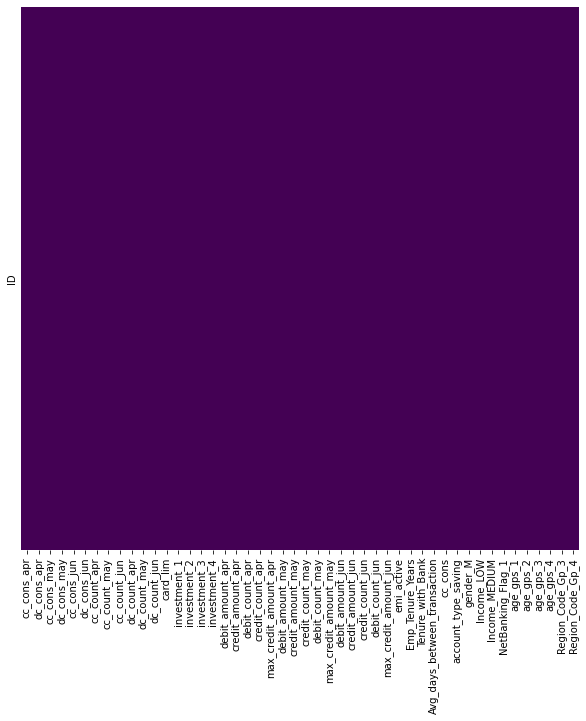

In [43]:
plt.figure(figsize = (10, 10))
sns.heatmap(main.isnull(), cbar = False, cmap = 'viridis', yticklabels = False)
plt.show()

In [44]:
# Since percentage of missing values are less than 5% of the total values, we can safely drop these missing values
main.dropna(inplace = True)
print(main.shape)
main.isna().sum()

(14997, 48)


cc_cons_apr                     0
dc_cons_apr                     0
cc_cons_may                     0
dc_cons_may                     0
cc_cons_jun                     0
dc_cons_jun                     0
cc_count_apr                    0
cc_count_may                    0
cc_count_jun                    0
dc_count_apr                    0
dc_count_may                    0
dc_count_jun                    0
card_lim                        0
investment_1                    0
investment_2                    0
investment_3                    0
investment_4                    0
debit_amount_apr                0
credit_amount_apr               0
debit_count_apr                 0
credit_count_apr                0
max_credit_amount_apr           0
debit_amount_may                0
credit_amount_may               0
credit_count_may                0
debit_count_may                 0
max_credit_amount_may           0
debit_amount_jun                0
credit_amount_jun               0
credit_count_j

### Checking the assumption for the normal distribution for the response variable

/Users/shamshersingh/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


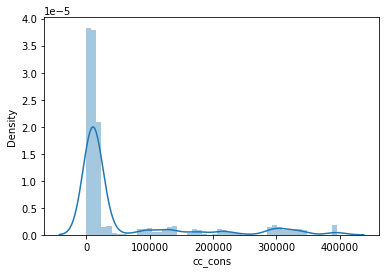

In [45]:
sns.distplot(main.cc_cons)
plt.show()

In [46]:
main.cc_cons.skew()

2.1183577963110523

Since the data is right skewed, therefore we can use log transformation of the data. Log transformation will shift high values of the data towards the lower side while not changing the smaller values much. log of 1000 is 3 while log of 10 is 1. 

/Users/shamshersingh/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


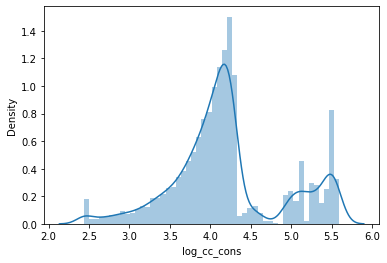

In [47]:
main['log_cc_cons'] = np.log10(main.cc_cons)
sns.distplot(main.log_cc_cons)
plt.show()

In [48]:
main.log_cc_cons.skew()

0.27314520472784604

#### with log transformation, although the distribution is brought to a near-normal distribution, however the skewness of the data has been reduced considerably

/Users/shamshersingh/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


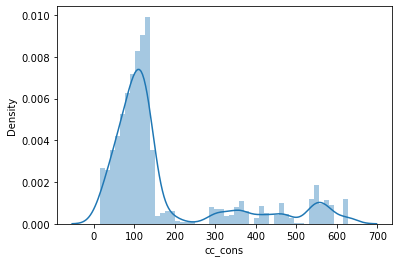

In [49]:
# checking for square root transformation
sns.distplot(np.sqrt(main.cc_cons))
plt.show()

In [50]:
np.sqrt(main.cc_cons).skew()

1.6123469903419683

The sqrt is not as effective as log transformation. Therefore we will keep log transformed response variable and drop sqrt transformed variable

### Checking the correlation among different predictor variables

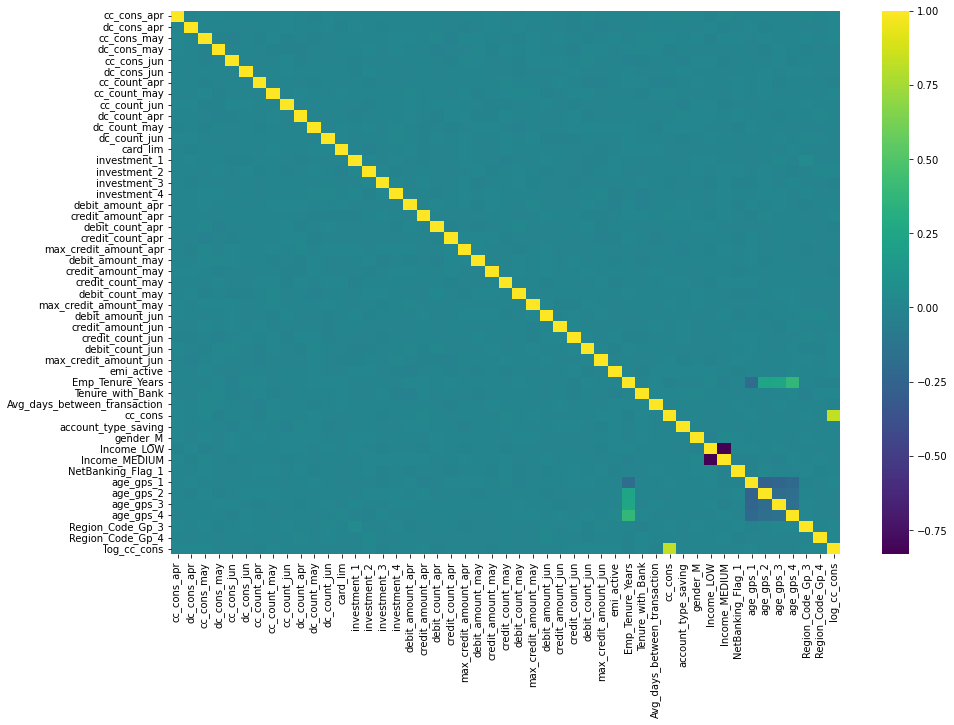

In [51]:
corrm = main.corr()
plt.figure(figsize = (15, 10))
sns.heatmap(corrm, cmap = 'viridis')
plt.show()

In [52]:
corrm.to_excel('corrm.xlsx')

From the correlation heatmap and matrix in excel, it is evident that there is no correlation among predictor variables except between Income_Medium and Income_Low. Further, there is some correlation between age groups and Emp_Tenure_Years which is understandable as higher the age higher will be the Employee tenure years. 

In [53]:
# another package to get the correlation matrix.
# from dython import nominal
# nominal.associations(main, figsize = (20, 20), mark_columns = True)

### Feature Selection using F-Regression

In [54]:
feature_columns = main.columns.difference(['cc_cons', 'log_cc_cons'])
features = main[feature_columns]
target = main.cc_cons
f_values, p_values = f_regression(features, target)
f_df = pd.DataFrame({'Features':feature_columns, 'F_values':f_values.round(4), 'p_values':p_values.round(4)})
f_df

,Features,F_values,p_values
0,Avg_days_between_transaction,0.4389,0.5077
1,Emp_Tenure_Years,1.4082,0.2354
2,Income_LOW,0.2873,0.5920
3,Income_MEDIUM,0.0076,0.9306
4,NetBanking_Flag_1,0.0360,0.8495
5,Region_Code_Gp_3,1.7715,0.1832
6,Region_Code_Gp_4,0.1966,0.6575
7,Tenure_with_Bank,1.9438,0.1633
8,account_type_saving,0.1218,0.7271
9,age_gps_1,2.0727,0.1500


In [55]:
# selecting features with p-value less than 0.1 for 90% significance
final_feature_columns = list(f_df.loc[f_df.p_values <= 0.1, 'Features'])
final_feature_columns

['cc_cons_may', 'cc_count_may', 'credit_amount_apr']

With the F_regression technique we are getting only three of the variables as significant. As of now we will include all the varialbes in the model and try to select the significant variables from the model summary. 

### Checking for multi-collinearity using VIF

In [56]:
X = pd.concat([main[feature_columns], main.log_cc_cons], axis = 1)
X = X.assign(const = 1)
VIF = pd.DataFrame()
VIF['Features'] = X.columns
VIF['VIF_values'] = [round(variance_inflation_factor(X.values, i),2) for i in range(X.shape[1])]
VIF

,Features,VIF_values
0,Avg_days_between_transaction,1.00
1,Emp_Tenure_Years,1.70
2,Income_LOW,3.25
3,Income_MEDIUM,3.25
4,NetBanking_Flag_1,1.00
5,Region_Code_Gp_3,1.01
6,Region_Code_Gp_4,1.00
7,Tenure_with_Bank,1.00
8,account_type_saving,1.00
9,age_gps_1,1.41


As per the values above, there is no multi-collinearity present in the data. A fact corroborated by the correlation matrix created above. 

### Splitting the data into train and test. 

In [57]:
# split the data into train_X, test_X, train_y, test_y for sklearn based models
# as of now we will not use final_feature_columns we got from F_regression feature selection technique. 
# We will first create model with all feature_columns

train_X, test_X, train_y, test_y = train_test_split(main[feature_columns], main['log_cc_cons'], test_size = 0.3, 
                                                   random_state = 12345)
print('Train_X', train_X.shape, '|', 'Train_y', train_y.shape, '|', 'Test_X', test_X.shape, '|', 'Test_y', test_y.shape)

Train_X (10497, 47) | Train_y (10497,) | Test_X (4500, 47) | Test_y (4500,)


In [58]:
# split the data into train and test for statsmodels.api based models

train, test = train_test_split(main, train_size = 0.7, random_state = 12345)
print('Train', train.shape, '|', 'Test', test.shape)

Train (10497, 49) | Test (4500, 49)


### Model Creation

### Model_0 with all the predictor variables

In [59]:
# Create the model will the predictor variables
model_equation = 'log_cc_cons ~' + '+'.join(main.columns.difference(['cc_cons', 'log_cc_cons']))

In [60]:
model_equation

'log_cc_cons ~Avg_days_between_transaction+Emp_Tenure_Years+Income_LOW+Income_MEDIUM+NetBanking_Flag_1+Region_Code_Gp_3+Region_Code_Gp_4+Tenure_with_Bank+account_type_saving+age_gps_1+age_gps_2+age_gps_3+age_gps_4+card_lim+cc_cons_apr+cc_cons_jun+cc_cons_may+cc_count_apr+cc_count_jun+cc_count_may+credit_amount_apr+credit_amount_jun+credit_amount_may+credit_count_apr+credit_count_jun+credit_count_may+dc_cons_apr+dc_cons_jun+dc_cons_may+dc_count_apr+dc_count_jun+dc_count_may+debit_amount_apr+debit_amount_jun+debit_amount_may+debit_count_apr+debit_count_jun+debit_count_may+emi_active+gender_M+investment_1+investment_2+investment_3+investment_4+max_credit_amount_apr+max_credit_amount_jun+max_credit_amount_may'

In [61]:
model_0 = smf.ols(formula = model_equation, data = train).fit()
print(model_0.summary())

                            OLS Regression Results                            
Dep. Variable:            log_cc_cons   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9366
Date:                Thu, 04 Aug 2022   Prob (F-statistic):              0.597
Time:                        21:06:46   Log-Likelihood:                -10835.
No. Observations:               10497   AIC:                         2.177e+04
Df Residuals:                   10449   BIC:                         2.211e+04
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

R2 and Adj R2 are very very low which means that predictor variables are not able to explain any variance in log_cc_cons. 

In [62]:
# creating second model with the predictor variables selected after f_regression and VIF
model_equation_1 = 'log_cc_cons ~ ' + '+'.join(final_feature_columns)
model_equation_1

'log_cc_cons ~ cc_cons_may+cc_count_may+credit_amount_apr'

In [63]:
model_1 = smf.ols(model_equation_1, train).fit()
print(model_1.summary())

                            OLS Regression Results                            
Dep. Variable:            log_cc_cons   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     4.941
Date:                Thu, 04 Aug 2022   Prob (F-statistic):            0.00198
Time:                        21:06:46   Log-Likelihood:                -10849.
No. Observations:               10497   AIC:                         2.171e+04
Df Residuals:                   10493   BIC:                         2.174e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             4.1507      0.01

Adj Rsq value improved while Rsq did not. Still this model is not good for predictions because of low Adj R2 values. 

### Going for stepwise regression (forward elimination)

In [64]:
def forward_selection(data, response):
    
    remaining_predictors = set(data.columns)
    remaining_predictors.remove(response)
    final_selected = []
    current_score, best_new_score = 0.0, 0.0
    
    while remaining_predictors and current_score == best_new_score:
        
        scores_with_candidates = []
        
        for candidate in remaining_predictors:
            
            formula = '{} ~ {}'.format(response, '+'.join(final_selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
            
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        
        if current_score < best_new_score:
            remaining_predictors.remove(best_candidate)
            final_selected.append(best_candidate)
            current_score = best_new_score
            
    formula = '{} ~ {}'.format(response, '+'.join(final_selected))
    model = smf.ols(formula, data).fit()
    return model

In [65]:
model_forSel = forward_selection(train[train.columns.difference(['cc_cons'])], 'log_cc_cons')

In [66]:
print(model_forSel.summary())

                            OLS Regression Results                            
Dep. Variable:            log_cc_cons   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.623
Date:                Thu, 04 Aug 2022   Prob (F-statistic):            0.00118
Time:                        21:06:56   Log-Likelihood:                -10840.
No. Observations:               10497   AIC:                         2.171e+04
Df Residuals:                   10483   BIC:                         2.181e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [67]:
model_forSel.model.formula

'log_cc_cons ~ credit_amount_apr+cc_cons_may+Region_Code_Gp_3+cc_count_may+cc_count_apr+max_credit_amount_jun+Emp_Tenure_Years+Income_MEDIUM+investment_3+Region_Code_Gp_4+debit_amount_may+debit_count_jun+Avg_days_between_transaction'

Again we have very low values of R2 and Adj R2. However it has best R2 and Adj R2 values among all the models so far, so using this model for predictions. 

### Predicting the output

In [68]:
# since we have taken log base 10 of the response variable, the predicted values will also be in the log base 10 format
# Therefore to convert the values back we need to take 10 to the power of each value
train['Predicted_y'] = 10**(model_forSel.predict(train))

/var/folders/vt/5tvfbhvx4g74ydhsmm2p5bmw0000gn/T/ipykernel_9305/2237926833.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Predicted_y'] = 10**(model_forSel.predict(train))


In [69]:
train[['cc_cons', 'Predicted_y']]

,cc_cons,Predicted_y
ID,,
5969,1858.0,14688.952638
10693,17352.0,15752.416650
17959,290592.0,18837.345442
5018,593.0,17707.813987
3940,6512.0,14509.164085
...,...,...
2534,20191.0,15428.008593
15735,34828.0,16612.529128
12032,9442.0,14836.670491


In [70]:
train[['cc_cons', 'Predicted_y']].mean().round(2)

cc_cons        54165.81
Predicted_y    15515.04
dtype: float64

There is considerable difference between the mean of actual and predicted y. As expected the model is not able to predict with high precision. 

In [71]:
train[['cc_cons', 'Predicted_y']].median().round(2)

cc_cons        13290.00
Predicted_y    15334.78
dtype: float64

In [72]:
# for test data
test['Predicted_y'] = 10**(model_forSel.predict(test))
test[['cc_cons', 'Predicted_y']]

/var/folders/vt/5tvfbhvx4g74ydhsmm2p5bmw0000gn/T/ipykernel_9305/548300829.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predicted_y'] = 10**(model_forSel.predict(test))


,cc_cons,Predicted_y
ID,,
3064,5953.0,13915.895225
4892,20119.0,15311.989918
17295,4590.0,14915.138209
3335,12443.0,14804.580315
7780,8277.0,16985.175074
...,...,...
16608,2495.0,15378.186272
535,244068.0,14551.004620
1119,888.0,15169.687940


In [73]:
test[['cc_cons', 'Predicted_y']].mean().round(2)

cc_cons        57246.03
Predicted_y    15497.12
dtype: float64

In [74]:
test[['cc_cons', 'Predicted_y']].median().round(2)

cc_cons        13509.50
Predicted_y    15359.56
dtype: float64

In [75]:
# Measuring the performance of the model
train_mse = round(mean_squared_error(train['cc_cons'], train['Predicted_y']), 2)
train_rmse = np.sqrt(train_mse).round(2)
train_mae = round(mean_absolute_error(train['cc_cons'], train['Predicted_y']), 2)
train_mape = round(mean_absolute_percentage_error(train['cc_cons'], train['Predicted_y']), 2)

test_mse = round(mean_squared_error(test['cc_cons'], test['Predicted_y']), 2)
test_rmse = np.sqrt(test_mse).round(2)
test_mae = round(mean_absolute_error(test['cc_cons'], test['Predicted_y']), 2)
test_mape = round(mean_absolute_percentage_error(test['cc_cons'], test['Predicted_y']), 2)

print('Train MSE', train_mse, '|', 'Test MSE', test_mse)
print('Train RMSE', train_rmse , '|', 'Test RMSE', test_rmse)
print('Train MAE', train_mae, '|', 'Test MAE', test_mae)
print('Train MAPE', train_mape , '|', 'Test MAPE', test_mape)

Train MSE 10806411376.3 | Test MSE 11624134521.93
Train RMSE 103953.89 | Test RMSE 107815.28
Train MAE 47620.99 | Test MAE 50738.89
Train MAPE 2.57 | Test MAPE 2.67


In [76]:
# Given the null model, the error should be:-
main['Mean_y'] = np.mean(main.cc_cons)
print('RMSE of the null model : ', np.sqrt(mean_squared_error(main.cc_cons, main.Mean_y)).round(2))

RMSE of the null model :  97430.33


So on an average we have an error of 97430.33 from the Null model. Any model should give error less than this and lower the error as compared to this value, better the model is. The null model has low error as compared to that of our model. Thus model_forSel is not good model. 

### Understanding relation between the actual y and the predicted y. A good model will produce predicted y with very good correlation with the actual y. If the correlation between both actual and predicted y is not good, then the model is either overfit or underfit and not suitable for predictions. 

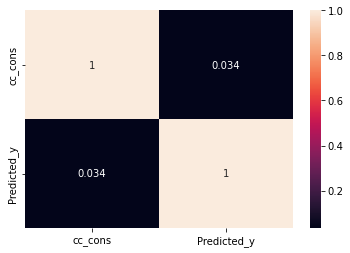

In [77]:
sns.heatmap(train[['cc_cons', 'Predicted_y']].corr(), annot = True)
plt.show()

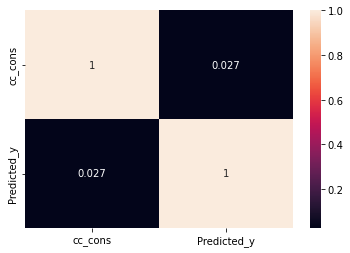

In [78]:
sns.heatmap(test[['cc_cons', 'Predicted_y']].corr(), annot = True)
plt.show()

There seems to be very poor correlation between actual and the predicted y which corborates the fact that this is not a good model. 

/Users/shamshersingh/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


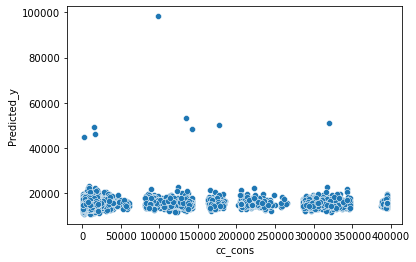

In [79]:
sns.scatterplot(train.cc_cons, train.Predicted_y)
plt.show()

/Users/shamshersingh/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


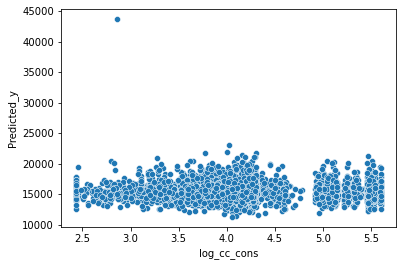

In [80]:
sns.scatterplot(test.log_cc_cons, test.Predicted_y)
plt.show()

### A good model will have normal distribution of Residuals - This is one of the assumptions of Linear Regression

/Users/shamshersingh/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


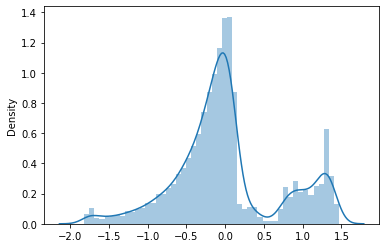

In [81]:
sns.distplot(model_forSel.resid)
plt.show()

As seen above, the residuals of the model_forSel has a distribution which is close to normal. 

### Plotting the four plots of Linear Regression 

In [82]:
# fitted values (need a constant term for intercept)
model_fitted_y = 10**(model_forSel.fittedvalues)

# model residuals
model_residuals = model_forSel.resid

# normalized residuals
model_norm_residuals = model_forSel.get_influence().resid_studentized_internal

# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))

# absolute residuals
model_abs_resid = np.abs(model_residuals)

# leverage, from statsmodels internals
model_leverage = model_forSel.get_influence().hat_matrix_diag

# cook's distance, from statsmodels internals
model_cooks = model_forSel.get_influence().cooks_distance[0]

/Users/shamshersingh/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:693: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)


/Users/shamshersingh/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


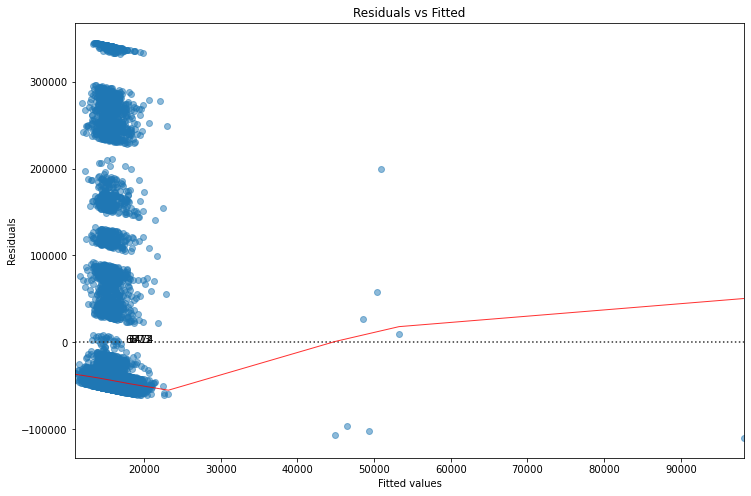

In [83]:
''' Residual vs Fitted Values is the first of the four plots of Linear Regression summary. It is a scatter plot 
of residuals vs fitted values with locally weighted scatterplot smoothing (lowess) regression line showing any 
apparent trend. 
'''


plot_lm_1 = plt.figure(1)
plot_lm_1.set_figheight(8)
plot_lm_1.set_figwidth(12)

plot_lm_1.axes[0] = sns.residplot(model_fitted_y, 'cc_cons', data=train, 
                          lowess=True, 
                          scatter_kws={'alpha': 0.5}, 
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals')

# annotations
abs_resid = model_abs_resid.sort_values(ascending=False)
abs_resid_top_3 = abs_resid[:3]

for i in abs_resid_top_3.index:
    plot_lm_1.axes[0].annotate(i, 
                               xy=(model_fitted_y[i], 
                                   model_residuals[i]));

/Users/shamshersingh/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/Users/shamshersingh/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


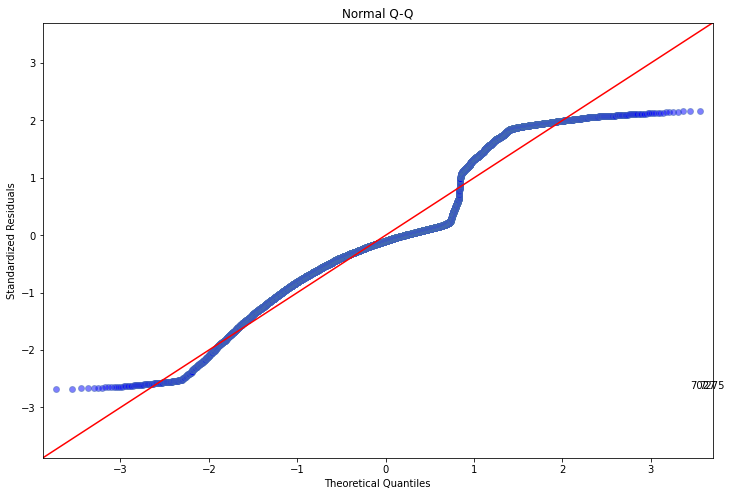

In [84]:
# QQ plot shows how well the distribution of residuals fit the normal distribution. This plot standardizes (z-score)
# the residuals against theoritical normal quantiles. Anything off the diagnol line is a cause for further 
# investigation

from statsmodels.graphics.gofplots import ProbPlot

QQ = ProbPlot(model_norm_residuals)
plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)

plot_lm_2.set_figheight(8)
plot_lm_2.set_figwidth(12)

plot_lm_2.axes[0].set_title('Normal Q-Q')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardized Residuals');

# annotations
abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
abs_norm_resid_top_3 = abs_norm_resid[:3]

for r, i in enumerate(abs_norm_resid_top_3):
    plot_lm_2.axes[0].annotate(i, 
                               xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                   model_norm_residuals[i]));

/Users/shamshersingh/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


KeyError: 802

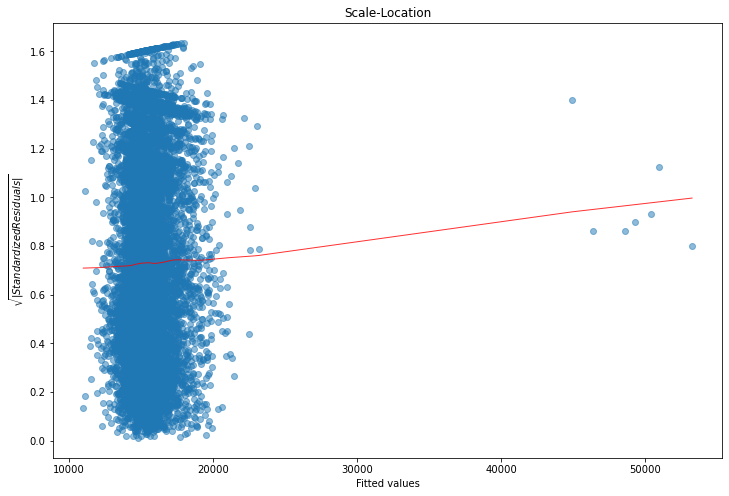

In [85]:
# Scale location plot - this is another residual plot showing the spread of residuals and which can be used to 
# detect heteroskedasticity. 

plot_lm_3 = plt.figure(3)
plot_lm_3.set_figheight(8)
plot_lm_3.set_figwidth(12)

plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5)
sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt, 
            scatter=False, 
            ci=False, 
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_3.axes[0].set_title('Scale-Location')
plot_lm_3.axes[0].set_xlabel('Fitted values')
plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');

# annotations
abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]

for i in abs_norm_resid_top_3:
    plot_lm_3.axes[0].annotate(i, 
                               xy=(model_fitted_y[i], 
                                   model_norm_residuals_abs_sqrt[i]));

/Users/shamshersingh/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


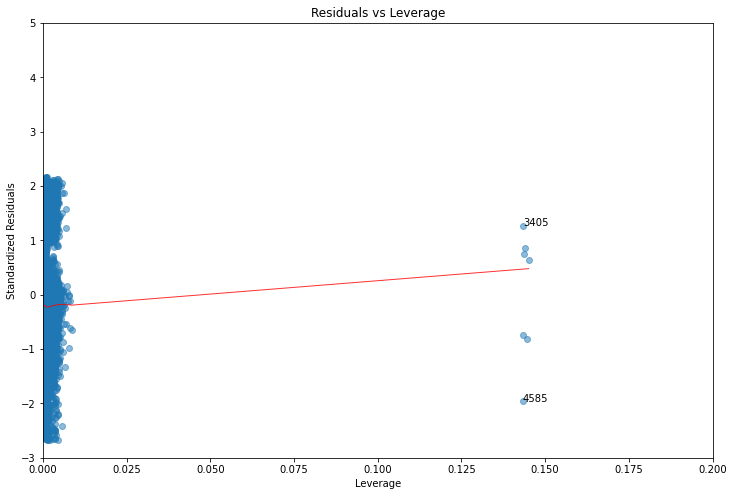

In [86]:
'''
This plot shows if there are any outliers which have influence on the model fit. Anything outside the group and
outside Cook's Distance lines may have an influential effect on the model fit. 
'''

plot_lm_4 = plt.figure(4)
plot_lm_4.set_figheight(8)
plot_lm_4.set_figwidth(12)

plt.scatter(model_leverage, model_norm_residuals, alpha=0.5)
sns.regplot(model_leverage, model_norm_residuals, 
            scatter=False, 
            ci=False, 
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_4.axes[0].set_xlim(0, 0.20)
plot_lm_4.axes[0].set_ylim(-3, 5)
plot_lm_4.axes[0].set_title('Residuals vs Leverage')
plot_lm_4.axes[0].set_xlabel('Leverage')
plot_lm_4.axes[0].set_ylabel('Standardized Residuals')

# annotations
leverage_top_3 = np.flip(np.argsort(model_cooks), 0)[:3]

for i in leverage_top_3:
    plot_lm_4.axes[0].annotate(i, 
                               xy=(model_leverage[i], 
                                   model_norm_residuals[i]))

## Decile Analysis

Decile analysis is used to find out where is the problem in the data which has led the model to give not good results. In this analysis we select actual and predicted y, create 10 deciles of data based on predicted y and take mean of each decile of actual and predicted y. We then compare the means of each decile. 

Ideally, the mean of deciles of both the actual and the predicted y should decrease as we go from 10th decile to 1st decile. That will happen when our predictions follow the actual values closely. 

In case there are some deviations, that will reflect in the decile means. 

The basic idea of Decile analysis is to group the data into 10 gps and compare the average of each gp and try to find out the abnormalities in the data as it is difficult to compare each and every data point to find out where the real difference in the predicted and actual value lies. 

In [87]:
train['Decile'] = pd.qcut(train.Predicted_y, 10, labels = False)
train_decile_analysis = train.groupby('Decile')[['cc_cons', 
                                                 'Predicted_y']].mean().sort_index(ascending = False).reset_index()
train_decile_analysis

/var/folders/vt/5tvfbhvx4g74ydhsmm2p5bmw0000gn/T/ipykernel_9305/2877899628.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Decile'] = pd.qcut(train.Predicted_y, 10, labels = False)


,Decile,cc_cons,Predicted_y
0,9,59235.417533,18436.466848
1,8,55113.772571,16694.639025
2,7,53487.703832,16159.227908
3,6,57961.132962,15788.803112
4,5,54390.091058,15478.059337
5,4,54511.170105,15205.376083
6,3,55942.451238,14945.099533
7,2,51226.067016,14661.389495
8,1,54544.028476,14298.115982
9,0,45243.013619,13482.966911


Although the mean values of both the columns is decreasing gradually, there is very high differences between the averages of deciles of two groups indicating that the model is not good at all.  

### Applying Machine Learning - Lasso (L1), Ridge (L2) and Elastic Net (L1 + L2) Regression on the data above

In [88]:
from sklearn import linear_model 
from sklearn.model_selection import GridSearchCV

### Model without any regularization and cross-validation

In [89]:
lm_model = linear_model.LinearRegression().fit(train_X, train_y)

In [90]:
print(f'Intercept : {lm_model.intercept_:.4f}')
print('\nCoefficients\n')
for name, coeff in zip(train_X.columns, lm_model.coef_):
    print(f'{name} : {coeff:.4f}')

Intercept : 4.1570

Coefficients

Avg_days_between_transaction : -0.0013
Emp_Tenure_Years : -0.0016
Income_LOW : -0.0041
Income_MEDIUM : -0.0212
NetBanking_Flag_1 : 0.0080
Region_Code_Gp_3 : 0.4706
Region_Code_Gp_4 : 0.8407
Tenure_with_Bank : 0.0020
account_type_saving : -0.0067
age_gps_1 : 0.0184
age_gps_2 : 0.0316
age_gps_3 : 0.0255
age_gps_4 : 0.0404
card_lim : -0.0000
cc_cons_apr : 0.0000
cc_cons_jun : 0.0000
cc_cons_may : 0.0000
cc_count_apr : -0.0001
cc_count_jun : 0.0001
cc_count_may : 0.0004
credit_amount_apr : 0.0000
credit_amount_jun : 0.0000
credit_amount_may : -0.0000
credit_count_apr : 0.0003
credit_count_jun : 0.0001
credit_count_may : 0.0001
dc_cons_apr : 0.0000
dc_cons_jun : -0.0000
dc_cons_may : -0.0000
dc_count_apr : -0.0000
dc_count_jun : -0.0002
dc_count_may : 0.0000
debit_amount_apr : 0.0000
debit_amount_jun : -0.0000
debit_amount_may : -0.0000
debit_count_apr : -0.0001
debit_count_jun : 0.0002
debit_count_may : -0.0000
emi_active : 0.0000
gender_M : 0.0110
investm

In [91]:
linReg_Coeff = pd.DataFrame(data = {'Predictors':train_X.columns, 'Coefficients':lm_model.coef_.round(4)})
linReg_Coeff

,Predictors,Coefficients
0,Avg_days_between_transaction,-0.0013
1,Emp_Tenure_Years,-0.0016
2,Income_LOW,-0.0041
3,Income_MEDIUM,-0.0212
4,NetBanking_Flag_1,0.0080
5,Region_Code_Gp_3,0.4706
6,Region_Code_Gp_4,0.8407
7,Tenure_with_Bank,0.0020
8,account_type_saving,-0.0067
9,age_gps_1,0.0184


In [92]:
intercept = pd.DataFrame(['Intercept', lm_model.intercept_]).T
intercept.rename(columns = {0:'Predictors', 1:'Coefficients'}, inplace = True)
linReg_Coeff = pd.concat((linReg_Coeff,intercept ))
linReg_Coeff

,Predictors,Coefficients
0,Avg_days_between_transaction,-0.0013
1,Emp_Tenure_Years,-0.0016
2,Income_LOW,-0.0041
3,Income_MEDIUM,-0.0212
4,NetBanking_Flag_1,0.008
5,Region_Code_Gp_3,0.4706
6,Region_Code_Gp_4,0.8407
7,Tenure_with_Bank,0.002
8,account_type_saving,-0.0067
9,age_gps_1,0.0184


In [93]:
# predict the values
y_train_pred = lm_model.predict(train_X)
y_test_pred = lm_model.predict(test_X)

In [94]:
# evaluating the model

print('R2 Train :', r2_score(train_y, y_train_pred))
print('R2 Test :', r2_score(test_y, y_test_pred))
print('\n')
print('MAE Train :', mean_absolute_error(train_y, y_train_pred))
print('MAE Test :', mean_absolute_error(test_y, y_test_pred))
print('\n')
print('MAPE Train :', mean_absolute_percentage_error(train_y, y_train_pred))
print('MAPE Test :', mean_absolute_percentage_error(test_y, y_test_pred))
print('\n')
print('MSE Train :', mean_squared_error(train_y, y_train_pred))
print('MSE Test :', mean_squared_error(test_y, y_test_pred))

R2 Train : 0.004195060826705177
R2 Test : -0.0019309267392570995


MAE Train : 0.49239832121274174
MAE Test : 0.5124547198705962


MAPE Train : 0.12157651882199327
MAPE Test : 0.12600320784722543


MSE Train : 0.4613769993549082
MSE Test : 0.48817911579268386


The model accuracies on both test and train data are same which means that model is not good and is underfit. 

### Implementing stepwise regression using dmba package

In [95]:
train_X.columns

Index(['Avg_days_between_transaction', 'Emp_Tenure_Years', 'Income_LOW',
       'Income_MEDIUM', 'NetBanking_Flag_1', 'Region_Code_Gp_3',
       'Region_Code_Gp_4', 'Tenure_with_Bank', 'account_type_saving',
       'age_gps_1', 'age_gps_2', 'age_gps_3', 'age_gps_4', 'card_lim',
       'cc_cons_apr', 'cc_cons_jun', 'cc_cons_may', 'cc_count_apr',
       'cc_count_jun', 'cc_count_may', 'credit_amount_apr',
       'credit_amount_jun', 'credit_amount_may', 'credit_count_apr',
       'credit_count_jun', 'credit_count_may', 'dc_cons_apr', 'dc_cons_jun',
       'dc_cons_may', 'dc_count_apr', 'dc_count_jun', 'dc_count_may',
       'debit_amount_apr', 'debit_amount_jun', 'debit_amount_may',
       'debit_count_apr', 'debit_count_jun', 'debit_count_may', 'emi_active',
       'gender_M', 'investment_1', 'investment_2', 'investment_3',
       'investment_4', 'max_credit_amount_apr', 'max_credit_amount_jun',
       'max_credit_amount_may'],
      dtype='object')

In [96]:
train_y

ID
5969     3.269046
10693    4.239350
17959    5.463284
5018     2.773055
3940     3.813714
           ...   
2534     4.305158
15735    4.541929
12032    3.975064
10763    3.824646
201      4.939629
Name: log_cc_cons, Length: 10497, dtype: float64

In [97]:
import dmba

no display found. Using non-interactive Agg backend


In [98]:
# define a function that returns a model for given set of variables
def train_model(variables):
    if len(variables) == 0:
        return None
    model = linear_model.LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

In [99]:
# Define a model that returns score for a given model and set of variables. In this case we use AIC_score implemented
# in the dmba package
def score_model(model, variables):
    if len(variables) == 0:
        return dmba.AIC_score(train_y , [train_y.mean()] * len(train_y), model, df = 1)
    return dmba.AIC_score(train_y, model.predict(train_X[variables]), model)

In [100]:
best_model_fwd, best_variables_fwd = dmba.stepwise_selection(train_X.columns, train_model, score_model, 
                                                             direction = 'forward', verbose = True)

print(f'\nBest_Intercept : {best_model_fwd.intercept_:.3f}')
print('\nCoefficients : ')
for name, coeff in zip(best_variables_fwd, best_model_fwd.coef_):
    print(f'{name} : {coeff}')

Variables: Avg_days_between_transaction, Emp_Tenure_Years, Income_LOW, Income_MEDIUM, NetBanking_Flag_1, Region_Code_Gp_3, Region_Code_Gp_4, Tenure_with_Bank, account_type_saving, age_gps_1, age_gps_2, age_gps_3, age_gps_4, card_lim, cc_cons_apr, cc_cons_jun, cc_cons_may, cc_count_apr, cc_count_jun, cc_count_may, credit_amount_apr, credit_amount_jun, credit_amount_may, credit_count_apr, credit_count_jun, credit_count_may, dc_cons_apr, dc_cons_jun, dc_cons_may, dc_count_apr, dc_count_jun, dc_count_may, debit_amount_apr, debit_amount_jun, debit_amount_may, debit_count_apr, debit_count_jun, debit_count_may, emi_active, gender_M, investment_1, investment_2, investment_3, investment_4, max_credit_amount_apr, max_credit_amount_jun, max_credit_amount_may
Start: score=21717.48, constant
Step: score=21713.73, add credit_amount_apr
Step: score=21710.30, add cc_cons_may
Step: score=21708.62, add Region_Code_Gp_3
Step: score=21706.99, add cc_count_may
Step: score=21705.89, add cc_count_apr
Step: s

In [101]:
best_model_bwd, best_variables_bwd = dmba.stepwise_selection(train_X.columns, train_model, score_model, 
                                                             direction = 'backward', verbose = True)

print(f'\nBest_Intercept : {best_model_bwd.intercept_:.3f}')
print('\nCoefficients : ')
for name, coeff in zip(best_variables_bwd, best_model_bwd.coef_):
    print(f'{name} : {coeff}')

Variables: Avg_days_between_transaction, Emp_Tenure_Years, Income_LOW, Income_MEDIUM, NetBanking_Flag_1, Region_Code_Gp_3, Region_Code_Gp_4, Tenure_with_Bank, account_type_saving, age_gps_1, age_gps_2, age_gps_3, age_gps_4, card_lim, cc_cons_apr, cc_cons_jun, cc_cons_may, cc_count_apr, cc_count_jun, cc_count_may, credit_amount_apr, credit_amount_jun, credit_amount_may, credit_count_apr, credit_count_jun, credit_count_may, dc_cons_apr, dc_cons_jun, dc_cons_may, dc_count_apr, dc_count_jun, dc_count_may, debit_amount_apr, debit_amount_jun, debit_amount_may, debit_count_apr, debit_count_jun, debit_count_may, emi_active, gender_M, investment_1, investment_2, investment_3, investment_4, max_credit_amount_apr, max_credit_amount_jun, max_credit_amount_may
Start: score=21767.35, constant
Step: score=21765.35, remove max_credit_amount_apr
Step: score=21763.35, remove investment_4
Step: score=21761.35, remove investment_1
Step: score=21759.36, remove emi_active
Step: score=21757.36, remove dc_cou

In [102]:
best_model_both, best_variables_both = dmba.stepwise_selection(train_X.columns, train_model, score_model, 
                                                               direction = 'both', verbose = True)

print(f'\nBest_Intercetp : {best_model_both.intercept_:.3f}')
print('\nCoefficients : ')
for name, coeff in zip(best_variables_both, best_model_both.coef_):
    print(f'{name} : {coeff}')

Variables: Avg_days_between_transaction, Emp_Tenure_Years, Income_LOW, Income_MEDIUM, NetBanking_Flag_1, Region_Code_Gp_3, Region_Code_Gp_4, Tenure_with_Bank, account_type_saving, age_gps_1, age_gps_2, age_gps_3, age_gps_4, card_lim, cc_cons_apr, cc_cons_jun, cc_cons_may, cc_count_apr, cc_count_jun, cc_count_may, credit_amount_apr, credit_amount_jun, credit_amount_may, credit_count_apr, credit_count_jun, credit_count_may, dc_cons_apr, dc_cons_jun, dc_cons_may, dc_count_apr, dc_count_jun, dc_count_may, debit_amount_apr, debit_amount_jun, debit_amount_may, debit_count_apr, debit_count_jun, debit_count_may, emi_active, gender_M, investment_1, investment_2, investment_3, investment_4, max_credit_amount_apr, max_credit_amount_jun, max_credit_amount_may
Start: score=21717.48, constant
Step: score=21713.73, add credit_amount_apr
Step: score=21710.30, add cc_cons_may
Step: score=21708.62, add Region_Code_Gp_3
Step: score=21706.99, add cc_count_may
Step: score=21705.89, add cc_count_apr
Step: s

In [103]:
model_equation_stepwise_fwd = 'log_cc_cons ~ ' + '+'.join(best_variables_fwd)
model_stepwise_fwd = smf.ols(model_equation_stepwise_fwd, data = main).fit()
print(model_stepwise_fwd.summary())

                            OLS Regression Results                            
Dep. Variable:            log_cc_cons   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     3.761
Date:                Thu, 04 Aug 2022   Prob (F-statistic):           0.000962
Time:                        21:09:58   Log-Likelihood:                -15616.
No. Observations:               14997   AIC:                         3.125e+04
Df Residuals:                   14990   BIC:                         3.130e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 4.15

In [104]:
model_equation_stepwise_bwd = 'log_cc_cons ~ ' + '+'.join(best_variables_bwd)
model_stepwise_bwd = smf.ols(model_equation_stepwise_bwd, data = main).fit()
print(model_stepwise_bwd.summary())

                            OLS Regression Results                            
Dep. Variable:            log_cc_cons   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     3.761
Date:                Thu, 04 Aug 2022   Prob (F-statistic):           0.000962
Time:                        21:09:58   Log-Likelihood:                -15616.
No. Observations:               14997   AIC:                         3.125e+04
Df Residuals:                   14990   BIC:                         3.130e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 4.15

In [105]:
model_equation_stepwise_both = 'log_cc_cons ~ ' + '+'.join(best_variables_both)
model_stepwise_both = smf.ols(model_equation_stepwise_both, data = main).fit()
print(model_stepwise_both.summary())

                            OLS Regression Results                            
Dep. Variable:            log_cc_cons   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     3.761
Date:                Thu, 04 Aug 2022   Prob (F-statistic):           0.000962
Time:                        21:09:58   Log-Likelihood:                -15616.
No. Observations:               14997   AIC:                         3.125e+04
Df Residuals:                   14990   BIC:                         3.130e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 4.15

#### No difference in the model goodness of fit even after deploying forward, backward and both stepwise regression. 

# Deploying Machine Learning Models

### Using Lasso, Ridge and Elastic Net for Feature Selection, 

In [106]:
from sklearn.model_selection import GridSearchCV

In [107]:
# Initializing the model
tuned_parameters = {'alpha' : [1, 10 , 100, 1000, 5000, 100000]}

RidgeCV = GridSearchCV(linear_model.Ridge(), 
                      tuned_parameters, 
                      cv = 10, 
                      n_jobs = -1, 
                      scoring = 'neg_mean_squared_error',
                      verbose = 1).fit(train_X, train_y)

print('Best Combination : ', RidgeCV.best_params_)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


/Users/shamshersingh/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.16684e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/shamshersingh/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.1832e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/shamshersingh/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.50913e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/shamshersingh/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.98162e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/shamshersingh/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_

Best Combination :  {'alpha': 100000}


In [108]:
tuned_parameters = {'alpha' : [1, 10 , 100, 1000, 5000, 100000]}

LassoCV = GridSearchCV(linear_model.Lasso(),
                      tuned_parameters, 
                      cv = 10, 
                      n_jobs = -1, 
                      scoring = 'neg_mean_squared_error',
                      verbose = 1).fit(train_X, train_y)

print('Best Combination : ', LassoCV.best_params_)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
Best Combination :  {'alpha': 100000}


In [109]:
tuned_parameters = {'alpha' : [1, 10 , 100, 1000, 5000, 100000]}

ElasticCV = GridSearchCV(linear_model.ElasticNet(), 
                        tuned_parameters, 
                        cv = 10, 
                        n_jobs = -1, 
                        scoring = 'neg_mean_squared_error', 
                        verbose = 1).fit(train_X, train_y)

print('Best Combination :', ElasticCV.best_params_)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
Best Combination : {'alpha': 100000}


### The Lasso, Ridge and ElasticNet are not able to model the data as the models are not able to settle down at particular hyper-parameters. In this case we can conclude that y and X do not follow linear relationship. Also y variable does not follow the normal distribution. 

### Using non-parametric techniques like Decision Tree for this problem

In Machine Learning models, it is good to use all the dummy variables since ML models are not susecptible to the dummy variable trap. 

In [110]:
main_ML.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 17051 to 4547
Data columns (total 43 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   cc_cons_apr                   15000 non-null  float64 
 1   dc_cons_apr                   15000 non-null  float64 
 2   cc_cons_may                   15000 non-null  float64 
 3   dc_cons_may                   15000 non-null  float64 
 4   cc_cons_jun                   15000 non-null  float64 
 5   dc_cons_jun                   15000 non-null  float64 
 6   cc_count_apr                  14999 non-null  float64 
 7   cc_count_may                  15000 non-null  int64   
 8   cc_count_jun                  15000 non-null  int64   
 9   dc_count_apr                  15000 non-null  int64   
 10  dc_count_may                  15000 non-null  int64   
 11  dc_count_jun                  15000 non-null  int64   
 12  card_lim                      15000 non-nul

In [111]:
num_data = main_ML.select_dtypes(['int', 'float'])
cat_data = main_ML.select_dtypes(['category', 'object'])

### Missing value treatment

In [112]:
num_data.fillna(num_data.mean(), inplace = True)
num_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 17051 to 4547
Data columns (total 37 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   cc_cons_apr                   15000 non-null  float64
 1   dc_cons_apr                   15000 non-null  float64
 2   cc_cons_may                   15000 non-null  float64
 3   dc_cons_may                   15000 non-null  float64
 4   cc_cons_jun                   15000 non-null  float64
 5   dc_cons_jun                   15000 non-null  float64
 6   cc_count_apr                  15000 non-null  float64
 7   cc_count_may                  15000 non-null  int64  
 8   cc_count_jun                  15000 non-null  int64  
 9   dc_count_apr                  15000 non-null  int64  
 10  dc_count_may                  15000 non-null  int64  
 11  dc_count_jun                  15000 non-null  int64  
 12  card_lim                      15000 non-null  int64  
 13

/Users/shamshersingh/opt/anaconda3/lib/python3.9/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


### Outlier Treatment

In [113]:
num_data.apply(eda)

,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,cc_count_jun,dc_count_apr,dc_count_may,dc_count_jun,card_lim,investment_1,investment_2,investment_3,investment_4,debit_amount_apr,credit_amount_apr,debit_count_apr,credit_count_apr,max_credit_amount_apr,debit_amount_may,credit_amount_may,credit_count_may,debit_count_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,emi_active,Emp_Tenure_Years,Tenure_with_Bank,Avg_days_between_transaction,cc_cons
Total,1.500000e+04,1.500000e+04,1.500000e+04,1.500000e+04,1.500000e+04,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,1.500000e+04,1.500000e+04,1.500000e+04,1.500000e+04,1.500000e+04,1.500000e+04,1.500000e+04,15000.000000,15000.000000,1.500000e+04,1.500000e+04,1.500000e+04,15000.000000,15000.000000,1.500000e+04,1.500000e+04,1.500000e+04,15000.000000,15000.000000,1.500000e+04,1.500000e+04,15000.000000,15000.000000,15000.000000,1.500000e+04
TotalMissing,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00
PercMissing,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00
Mean,1.795739e+04,8.171098e+03,1.633705e+04,7.703605e+03,1.212901e+04,7.097395e+03,41.489499,33.490200,41.507000,17.171000,13.979733,30.287267,2.770051e+05,6.194140e+05,2.333642e+05,4.444094e+04,3.523049e+03,6.823421e+04,8.079761e+04,36.402227,11.291400,5.438954e+04,6.554492e+04,8.356935e+04,11.923133,40.996867,5.718791e+04,7.615987e+04,7.850316e+04,19.946400,44.647867,5.258654e+04,1.576139e+04,13.084700,5.510000,11.049603,5.515773e+04
Std,2.518794e+04,1.477303e+04,2.706085e+04,1.898730e+04,1.848878e+04,1.325170e+04,97.432146,49.540999,47.342918,19.359678,17.087203,29.252490,1.794295e+05,3.087815e+06,4.073237e+05,8.811206e+04,7.373355e+03,1.126786e+05,1.989060e+05,30.700057,12.670785,1.950943e+05,1.016829e+05,1.776300e+05,16.843563,40.537354,2.000194e+05,1.545112e+05,1.482005e+05,27.200165,35.089082,1.282601e+05,1.179152e+05,10.366972,2.865783,5.492196,9.767097e+04
Var,6.344323e+08,2.182424e+08,7.322896e+08,3.605174e+08,3.418350e+08,1.756074e+08,9493.023141,2454.310591,2241.351908,374.797145,291.972521,855.708192,3.219496e+10,9.534600e+12,1.659126e+11,7.763735e+09,5.436637e+07,1.269647e+10,3.956359e+10,942.493524,160.548789,3.806177e+10,1.033940e+10,3.155243e+10,283.705605,1643.277075,4.000774e+10,2.387371e+10,2.196337e+10,739.848984,1231.243685,1.645065e+10,1.390399e+10,107.474105,8.212714,30.164217,9.539619e+09
Min,2.530000e+02,1.935000e+01,1.570000e+02,2.200000e+01,6.500000e+01,6.200000e+01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000e+00,3.000000e-01,3.000000e+00,4.620000e+02,-1.217900e+04,4.010000e+00,6.138000e+01,0.000000,0.000000,1.000000e+00,2.820000e+01,1.061000e+01,0.000000,0.000000,2.500000e-01,5.230000e+00,1.188000e+01,1.000000,0.000000,6.000000e-02,0.000000e+00,0.500000,1.000000,2.000000,0.000000e+00
Lower_CutOff-IQR,-2.107993e+04,-9.923530e+03,-1.933195e+04,-8.209250e+03,-1.385925e+04,-7.998625e+03,-53.500000,-44.500000,-66.500000,-32.500000,-26.500000,-71.000000,-2.900000e+05,-2.273060e+05,-2.720675e+05,-6.789000e+04,-1.032750e+04,-5.497637e+04,-6.178750e+04,-50.500000,-23.500000,-2.713100e+04,-5.909250e+04,-7.832

In [114]:
num_data.clip(lower = num_data.quantile(0.01), upper = num_data.quantile(.99), axis = 1, inplace = True)
num_data.apply(eda)

/Users/shamshersingh/opt/anaconda3/lib/python3.9/site-packages/pandas/core/generic.py:9032: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._where(cond, other, inplace, axis, level, errors=errors)
/Users/shamshersingh/opt/anaconda3/lib/python3.9/site-packages/pandas/core/generic.py:9032: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._where(cond, other, inplace, axis, level, errors=errors)


,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,cc_count_jun,dc_count_apr,dc_count_may,dc_count_jun,card_lim,investment_1,investment_2,investment_3,investment_4,debit_amount_apr,credit_amount_apr,debit_count_apr,credit_count_apr,max_credit_amount_apr,debit_amount_may,credit_amount_may,credit_count_may,debit_count_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,emi_active,Emp_Tenure_Years,Tenure_with_Bank,Avg_days_between_transaction,cc_cons
Total,1.500000e+04,1.500000e+04,1.500000e+04,1.500000e+04,1.500000e+04,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,1.500000e+04,1.500000e+04,1.500000e+04,1.500000e+04,1.500000e+04,1.500000e+04,1.500000e+04,15000.000000,15000.000000,1.500000e+04,1.500000e+04,1.500000e+04,15000.000000,15000.000000,1.500000e+04,1.500000e+04,1.500000e+04,15000.000000,15000.000000,1.500000e+04,1.500000e+04,15000.000000,15000.000000,15000.000000,1.500000e+04
TotalMissing,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00
PercMissing,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00
Mean,1.740064e+04,7.666626e+03,1.570725e+04,7.140884e+03,1.163052e+04,6.765904e+03,41.489499,31.188267,39.814867,17.025667,13.929867,30.287267,2.762400e+05,4.983192e+05,2.204552e+05,4.444115e+04,3.490934e+03,6.468191e+04,7.452777e+04,36.408560,11.232400,4.828039e+04,6.258770e+04,7.719190e+04,11.921733,41.000867,4.977921e+04,7.074622e+04,7.286769e+04,19.946400,44.615467,4.801076e+04,1.023862e+04,13.078233,5.510000,11.049603,5.509103e+04
Std,2.112322e+04,1.050403e+04,2.050505e+04,1.014223e+04,1.449384e+04,1.044813e+04,97.432146,30.413562,32.333861,18.943020,16.933736,29.252490,1.767608e+05,1.753966e+06,3.141893e+05,8.811196e+04,7.029362e+03,7.508783e+04,8.900265e+04,30.692649,12.474613,5.422007e+04,7.355587e+04,8.800847e+04,16.838693,40.533357,5.663187e+04,7.992528e+04,8.600239e+04,27.200165,35.011550,5.777848e+04,2.187331e+04,10.346175,2.865783,5.492196,9.742949e+04
Var,4.461906e+08,1.103347e+08,4.204569e+08,1.028648e+08,2.100715e+08,1.091633e+08,9493.023141,924.984755,1045.478558,358.837997,286.751398,855.708192,3.124439e+10,3.076395e+12,9.871489e+10,7.763717e+09,4.941193e+07,5.638182e+09,7.921472e+09,942.038692,155.615965,2.939816e+09,5.410467e+09,7.745490e+09,283.541577,1642.953063,3.207169e+09,6.388050e+09,7.396412e+09,739.848984,1225.808655,3.338353e+09,4.784416e+08,107.043330,8.212714,30.164217,9.492505e+09
Min,6.587669e+02,1.531400e+02,5.089800e+02,1.569510e+02,3.340000e+02,1.885000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.600000e+04,1.219000e+01,6.000000e+00,5.050000e+02,-7.652000e+03,1.993463e+02,4.860000e+02,1.000000,0.000000,4.689500e+02,1.083691e+03,2.970000e+02,0.000000,1.000000,1.299889e+02,1.077000e+03,2.929600e+02,1.000000,0.000000,1.630000e+02,2.668660e+01,0.900000,1.000000,2.000000,2.719900e+02
Lower_CutOff-IQR,-2.107993e+04,-9.923530e+03,-1.933195e+04,-8.209250e+03,-1.385925e+04,-7.998625e+03,-53.500000,-44.500000,-66.500000,-32.500000,-26.500000,-71.000000,-2.900000e+05,-2.273060e+05,-2.720675e+05,-6.789000e+04,-1.032750e+04,-5.497637e+04,-6.178750e+04,-50.500000,-23.500000,-2.713100e+04,-5.909250e+04,-7.8328

### Categorical Data

In [115]:
cat_data.apply(lambda x : x.nunique())

account_type       2
gender             2
Income             3
NetBanking_Flag    2
age_gps            5
Region_Code_Gp     3
dtype: int64

### In ML models it is desirable to have all the categories of categorical variables. Unlike statistical techniques where we are required to drop one of the dummy variables. 

In [116]:
cat_data['account_type'] = np.where(cat_data.account_type == 'current', 0, 1)
cat_data['gender'] = np.where(cat_data.gender == 'M', 0, 1)
cat_data['Income'] = cat_data['Income'].map({'LOW':0, 'MEDIUM':1, 'HIGH':2 })

/var/folders/vt/5tvfbhvx4g74ydhsmm2p5bmw0000gn/T/ipykernel_9305/4067350316.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_data['account_type'] = np.where(cat_data.account_type == 'current', 0, 1)
/var/folders/vt/5tvfbhvx4g74ydhsmm2p5bmw0000gn/T/ipykernel_9305/4067350316.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_data['gender'] = np.where(cat_data.gender == 'M', 0, 1)
/var/folders/vt/5tvfbhvx4g74ydhsmm2p5bmw0000gn/T/ipykernel_9305/4067350316.py:3: SettingWithCopyWarning: 
A value is try

In [117]:
main_ML = pd.concat([num_data, cat_data], axis = 1)
main_ML.head()

,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,cc_count_jun,dc_count_apr,dc_count_may,dc_count_jun,card_lim,investment_1,investment_2,investment_3,investment_4,debit_amount_apr,credit_amount_apr,debit_count_apr,credit_count_apr,max_credit_amount_apr,debit_amount_may,credit_amount_may,credit_count_may,debit_count_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,emi_active,Emp_Tenure_Years,Tenure_with_Bank,Avg_days_between_transaction,cc_cons,account_type,gender,Income,NetBanking_Flag,age_gps,Region_Code_Gp
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
17051,3412.60,2909.34,1077.36,3084.50,4615.97,6693.0,19.0,10,2,53,1,42,358000,331.2,130000.00,300500.0,12174.0,25210.23,27532.3700,103.0,36,28579.0,44974.63,42852.00,1,108,97916.0,45253.64,47635.00,2,18,19947.0,3448.84,7.0,5,20.0,13434.0,0,0,1,1,0,0
11491,18133.76,3877.00,6123.78,5597.43,64620.00,6117.0,4.0,60,1,4,1,17,114000,5809950.0,6.00,610000.0,2351.0,30937.00,50784.0000,40.0,35,25379.0,117575.67,24257.00,1,4,25125.0,12912.33,18369.00,3,49,20585.0,3812.69,10.2,8,5.0,449.0,0,0,0,1,1,0
7433,6363.65,735.49,8799.00,13768.00,38266.00,2638.0,2.0,83,47,4,62,42,360000,27324.0,176487.60,2156.0,3735.0,12940.25,26345.0000,11.0,3,19224.0,14646.35,38306.00,70,11,38546.0,93567.51,26713.00,47,49,13950.0,9432.90,3.9,3,15.0,11968.0,0,0,1,1,0,0
14606,12765.66,4429.16,16745.86,6360.00,29063.97,3711.0,12.0,2,16,24,12,58,155000,370776.0,63000.00,26241.0,0.0,78122.15,49660.0000,42.0,26,72186.0,14719.00,46132.05,43,1,180315.0,176394.48,35062.74,3,37,37018.0,144.61,25.8,6,15.0,32029.0,0,0,0,0,4,0
8381,27819.70,1944.00,7006.50,2228.50,1096.25,1065.0,15.0,13,61,7,5,80,362000,10006.2,7216.53,13873.0,-4679.0,6855.71,567755.1992,46.0,35,18867.0,189938.76,37191.00,2,14,13480.0,3167.00,19056.00,2,15,24274.0,1887.89,6.5,7,9.0,16394.0,1,0,1,0,0,0


In [118]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV

In [119]:
# splitting the data into X_train, X_test, y_train, y_test for sklearn based ML models
features = main_ML.columns.difference(['cc_cons'])
X_train, X_test, y_train, y_test = train_test_split(main_ML[features], main_ML.cc_cons, test_size = 0.3, 
                                                    random_state = 12345)

### Model without regularization and cross validation

In [120]:
tree_0 = DecisionTreeRegressor(random_state = 1).fit(X_train, y_train)

In [121]:
y_pred = tree_0.predict(X_train)
mse = mean_squared_error(y_train, y_pred)
print(mse)

0.0


In [122]:
pd.DataFrame(data = {'y_train':pd.Series(y_train).values, 'y_pred':pd.Series(y_pred).values})

,y_train,y_pred
0,258935.0,258935.0
1,15802.0,15802.0
2,31340.0,31340.0
3,19705.0,19705.0
4,830.0,830.0
...,...,...
10495,12881.0,12881.0
10496,132328.0,132328.0
10497,9442.0,9442.0
10498,8730.0,8730.0


The above zero value of MSE for DT model without regularization and cross validation shows that the model has learned the data. The tree has been split until there is only one data point in each leaf node and depth of tree has grown uncontrollably. 

### Model with cross-validation but without regularization

In [123]:
scores = cross_val_score (estimator = DecisionTreeRegressor(random_state = 1), 
                         X = X_train, 
                         y = y_train, 
                         cv = 10, 
                         scoring = 'neg_mean_squared_error', 
                         n_jobs = -1, 
                         verbose = 1)

print(np.mean(np.sqrt(-scores)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.9s remaining:    0.6s


144664.29715435623


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.6s finished


### Model with cross-validation and regularization

In [124]:
param_grid = {'max_depth' : range(3,7),
                  'min_samples_split' : range(2, 10), 
                      'min_samples_leaf' : range(2, 10)}

tree_1 = GridSearchCV(estimator = DecisionTreeRegressor(random_state = 1), 
                     param_grid = param_grid, 
                     cv = 10, 
                     n_jobs = -1, 
                     scoring = 'neg_mean_squared_error', 
                     verbose = 10, 
                     ).fit(X_train, y_train)

Fitting 10 folds for each of 256 candidates, totalling 2560 fits
[CV 1/10; 1/256] START max_depth=3, min_samples_leaf=2, min_samples_split=2.....
[CV 1/10; 1/256] END max_depth=3, min_samples_leaf=2, min_samples_split=2;, score=-9909300761.723 total time=   0.1s
[CV 9/10; 1/256] START max_depth=3, min_samples_leaf=2, min_samples_split=2.....
[CV 9/10; 1/256] END max_depth=3, min_samples_leaf=2, min_samples_split=2;, score=-9317025947.508 total time=   0.1s
[CV 7/10; 2/256] START max_depth=3, min_samples_leaf=2, min_samples_split=3.....
[CV 7/10; 2/256] END max_depth=3, min_samples_leaf=2, min_samples_split=3;, score=-9511134228.516 total time=   0.1s
[CV 8/10; 2/256] START max_depth=3, min_samples_leaf=2, min_samples_split=3.....
[CV 8/10; 2/256] END max_depth=3, min_samples_leaf=2, min_samples_split=3;, score=-9671508612.189 total time=   0.1s
[CV 5/10; 4/256] START max_depth=3, min_samples_leaf=2, min_samples_split=5.....
[CV 5/10; 4/256] END max_depth=3, min_samples_leaf=2, min_samp

[CV 3/10; 41/256] START max_depth=3, min_samples_leaf=7, min_samples_split=2....
[CV 3/10; 41/256] END max_depth=3, min_samples_leaf=7, min_samples_split=2;, score=-9448157106.481 total time=   0.1s
[CV 4/10; 41/256] START max_depth=3, min_samples_leaf=7, min_samples_split=2....
[CV 4/10; 41/256] END max_depth=3, min_samples_leaf=7, min_samples_split=2;, score=-9026111578.806 total time=   0.1s
[CV 9/10; 42/256] START max_depth=3, min_samples_leaf=7, min_samples_split=3....
[CV 9/10; 42/256] END max_depth=3, min_samples_leaf=7, min_samples_split=3;, score=-9317025947.508 total time=   0.1s
[CV 10/10; 42/256] START max_depth=3, min_samples_leaf=7, min_samples_split=3...
[CV 10/10; 42/256] END max_depth=3, min_samples_leaf=7, min_samples_split=3;, score=-9012815723.941 total time=   0.1s
[CV 5/10; 44/256] START max_depth=3, min_samples_leaf=7, min_samples_split=5....
[CV 5/10; 44/256] END max_depth=3, min_samples_leaf=7, min_samples_split=5;, score=-10340721437.028 total time=   0.1s
[CV

[CV 9/10; 67/256] START max_depth=4, min_samples_leaf=2, min_samples_split=4....
[CV 9/10; 67/256] END max_depth=4, min_samples_leaf=2, min_samples_split=4;, score=-9539499698.134 total time=   0.2s
[CV 10/10; 67/256] START max_depth=4, min_samples_leaf=2, min_samples_split=4...
[CV 10/10; 67/256] END max_depth=4, min_samples_leaf=2, min_samples_split=4;, score=-9327424483.332 total time=   0.2s
[CV 5/10; 69/256] START max_depth=4, min_samples_leaf=2, min_samples_split=6....
[CV 5/10; 69/256] END max_depth=4, min_samples_leaf=2, min_samples_split=6;, score=-10423111761.629 total time=   0.2s
[CV 6/10; 69/256] START max_depth=4, min_samples_leaf=2, min_samples_split=6....
[CV 6/10; 69/256] END max_depth=4, min_samples_leaf=2, min_samples_split=6;, score=-9920831632.823 total time=   0.2s
[CV 9/10; 70/256] START max_depth=4, min_samples_leaf=2, min_samples_split=7....
[CV 9/10; 70/256] END max_depth=4, min_samples_leaf=2, min_samples_split=7;, score=-9539499698.134 total time=   0.2s
[CV

[CV 10/10; 116/256] END max_depth=4, min_samples_leaf=8, min_samples_split=5;, score=-9115556558.234 total time=   0.2s
[CV 5/10; 118/256] START max_depth=4, min_samples_leaf=8, min_samples_split=7...
[CV 5/10; 118/256] END max_depth=4, min_samples_leaf=8, min_samples_split=7;, score=-10347073827.899 total time=   0.2s
[CV 6/10; 118/256] START max_depth=4, min_samples_leaf=8, min_samples_split=7...
[CV 6/10; 118/256] END max_depth=4, min_samples_leaf=8, min_samples_split=7;, score=-9832622876.941 total time=   0.2s
[CV 1/10; 120/256] START max_depth=4, min_samples_leaf=8, min_samples_split=9...
[CV 1/10; 120/256] END max_depth=4, min_samples_leaf=8, min_samples_split=9;, score=-9997203575.302 total time=   0.2s
[CV 2/10; 120/256] START max_depth=4, min_samples_leaf=8, min_samples_split=9...
[CV 2/10; 120/256] END max_depth=4, min_samples_leaf=8, min_samples_split=9;, score=-10135603761.117 total time=   0.2s
[CV 9/10; 121/256] START max_depth=4, min_samples_leaf=9, min_samples_split=2.

[CV 1/10; 68/256] START max_depth=4, min_samples_leaf=2, min_samples_split=5....
[CV 1/10; 68/256] END max_depth=4, min_samples_leaf=2, min_samples_split=5;, score=-9955670383.924 total time=   0.2s
[CV 2/10; 68/256] START max_depth=4, min_samples_leaf=2, min_samples_split=5....
[CV 2/10; 68/256] END max_depth=4, min_samples_leaf=2, min_samples_split=5;, score=-10249494682.044 total time=   0.2s
[CV 7/10; 69/256] START max_depth=4, min_samples_leaf=2, min_samples_split=6....
[CV 7/10; 69/256] END max_depth=4, min_samples_leaf=2, min_samples_split=6;, score=-9535536580.597 total time=   0.2s
[CV 8/10; 69/256] START max_depth=4, min_samples_leaf=2, min_samples_split=6....
[CV 8/10; 69/256] END max_depth=4, min_samples_leaf=2, min_samples_split=6;, score=-9725252316.742 total time=   0.2s
[CV 3/10; 71/256] START max_depth=4, min_samples_leaf=2, min_samples_split=8....
[CV 3/10; 71/256] END max_depth=4, min_samples_leaf=2, min_samples_split=8;, score=-9443365215.587 total time=   0.2s
[CV 

[CV 7/10; 67/256] START max_depth=4, min_samples_leaf=2, min_samples_split=4....
[CV 7/10; 67/256] END max_depth=4, min_samples_leaf=2, min_samples_split=4;, score=-9535536580.597 total time=   0.2s
[CV 8/10; 67/256] START max_depth=4, min_samples_leaf=2, min_samples_split=4....
[CV 8/10; 67/256] END max_depth=4, min_samples_leaf=2, min_samples_split=4;, score=-9725252316.742 total time=   0.2s
[CV 3/10; 69/256] START max_depth=4, min_samples_leaf=2, min_samples_split=6....
[CV 3/10; 69/256] END max_depth=4, min_samples_leaf=2, min_samples_split=6;, score=-9443365215.587 total time=   0.2s
[CV 4/10; 69/256] START max_depth=4, min_samples_leaf=2, min_samples_split=6....
[CV 4/10; 69/256] END max_depth=4, min_samples_leaf=2, min_samples_split=6;, score=-8894491327.323 total time=   0.2s
[CV 1/10; 71/256] START max_depth=4, min_samples_leaf=2, min_samples_split=8....
[CV 1/10; 71/256] END max_depth=4, min_samples_leaf=2, min_samples_split=8;, score=-9955670383.924 total time=   0.2s
[CV 2

[CV 6/10; 131/256] END max_depth=5, min_samples_leaf=2, min_samples_split=4;, score=-10255232107.114 total time=   0.2s
[CV 7/10; 132/256] START max_depth=5, min_samples_leaf=2, min_samples_split=5...
[CV 7/10; 132/256] END max_depth=5, min_samples_leaf=2, min_samples_split=5;, score=-9765276589.421 total time=   0.2s
[CV 8/10; 132/256] START max_depth=5, min_samples_leaf=2, min_samples_split=5...
[CV 8/10; 132/256] END max_depth=5, min_samples_leaf=2, min_samples_split=5;, score=-9671024621.521 total time=   0.2s
[CV 3/10; 134/256] START max_depth=5, min_samples_leaf=2, min_samples_split=7...
[CV 3/10; 134/256] END max_depth=5, min_samples_leaf=2, min_samples_split=7;, score=-9703971516.792 total time=   0.2s
[CV 4/10; 134/256] START max_depth=5, min_samples_leaf=2, min_samples_split=7...
[CV 4/10; 134/256] END max_depth=5, min_samples_leaf=2, min_samples_split=7;, score=-8899695951.136 total time=   0.2s
[CV 3/10; 136/256] START max_depth=5, min_samples_leaf=2, min_samples_split=9...

[CV 8/10; 130/256] END max_depth=5, min_samples_leaf=2, min_samples_split=3;, score=-9780163272.297 total time=   0.2s
[CV 3/10; 132/256] START max_depth=5, min_samples_leaf=2, min_samples_split=5...
[CV 3/10; 132/256] END max_depth=5, min_samples_leaf=2, min_samples_split=5;, score=-9703971516.792 total time=   0.2s
[CV 4/10; 132/256] START max_depth=5, min_samples_leaf=2, min_samples_split=5...
[CV 4/10; 132/256] END max_depth=5, min_samples_leaf=2, min_samples_split=5;, score=-8899695951.136 total time=   0.2s
[CV 9/10; 133/256] START max_depth=5, min_samples_leaf=2, min_samples_split=6...
[CV 9/10; 133/256] END max_depth=5, min_samples_leaf=2, min_samples_split=6;, score=-9688771904.377 total time=   0.2s
[CV 10/10; 133/256] START max_depth=5, min_samples_leaf=2, min_samples_split=6..
[CV 10/10; 133/256] END max_depth=5, min_samples_leaf=2, min_samples_split=6;, score=-9553464116.737 total time=   0.2s
[CV 7/10; 135/256] START max_depth=5, min_samples_leaf=2, min_samples_split=8...

[CV 4/10; 131/256] END max_depth=5, min_samples_leaf=2, min_samples_split=4;, score=-8899695951.136 total time=   0.2s
[CV 9/10; 132/256] START max_depth=5, min_samples_leaf=2, min_samples_split=5...
[CV 9/10; 132/256] END max_depth=5, min_samples_leaf=2, min_samples_split=5;, score=-9688771904.377 total time=   0.2s
[CV 10/10; 132/256] START max_depth=5, min_samples_leaf=2, min_samples_split=5..
[CV 10/10; 132/256] END max_depth=5, min_samples_leaf=2, min_samples_split=5;, score=-9553464116.737 total time=   0.2s
[CV 5/10; 134/256] START max_depth=5, min_samples_leaf=2, min_samples_split=7...
[CV 5/10; 134/256] END max_depth=5, min_samples_leaf=2, min_samples_split=7;, score=-10777418517.101 total time=   0.2s
[CV 6/10; 134/256] START max_depth=5, min_samples_leaf=2, min_samples_split=7...
[CV 6/10; 134/256] END max_depth=5, min_samples_leaf=2, min_samples_split=7;, score=-10255232107.114 total time=   0.2s
[CV 1/10; 136/256] START max_depth=5, min_samples_leaf=2, min_samples_split=9.

[CV 8/10; 131/256] END max_depth=5, min_samples_leaf=2, min_samples_split=4;, score=-9780163272.297 total time=   0.2s
[CV 3/10; 133/256] START max_depth=5, min_samples_leaf=2, min_samples_split=6...
[CV 3/10; 133/256] END max_depth=5, min_samples_leaf=2, min_samples_split=6;, score=-9703971516.792 total time=   0.2s
[CV 4/10; 133/256] START max_depth=5, min_samples_leaf=2, min_samples_split=6...
[CV 4/10; 133/256] END max_depth=5, min_samples_leaf=2, min_samples_split=6;, score=-8899695951.136 total time=   0.2s
[CV 9/10; 134/256] START max_depth=5, min_samples_leaf=2, min_samples_split=7...
[CV 9/10; 134/256] END max_depth=5, min_samples_leaf=2, min_samples_split=7;, score=-9688771904.377 total time=   0.2s
[CV 10/10; 134/256] START max_depth=5, min_samples_leaf=2, min_samples_split=7..
[CV 10/10; 134/256] END max_depth=5, min_samples_leaf=2, min_samples_split=7;, score=-9553464116.737 total time=   0.2s
[CV 5/10; 136/256] START max_depth=5, min_samples_leaf=2, min_samples_split=9...

In [125]:
print(tree_1.best_estimator_, '\n','\n','Best Score =', tree_1.best_score_)

DecisionTreeRegressor(max_depth=3, min_samples_leaf=4, random_state=1) 
 
 Best Score = -9607994635.719908


In [126]:
# RMSE of the DT model
y_pred = tree_1.best_estimator_.predict(X_train)
print(np.sqrt(mean_squared_error(y_train, y_pred)))

97153.10136880424


In [127]:
# RMSE of null model
main_ML['y_avg'] = np.mean(main_ML.cc_cons)
print(round(np.sqrt(mean_squared_error(main_ML.cc_cons, main_ML.y_avg)),2))

97426.24


tree_1 model gives slightly better results as compared to our null model. 

In [128]:
# list of values to try
max_depth_range = range(2, 7)

# list to store the average RMSE for each value of max_depth
RMSE_scores = []

# use LOOCV with each value of max_depth
for depth in max_depth_range:
    treereg = DecisionTreeRegressor( max_depth = depth, random_state = 345 )
    MSE_scores = cross_val_score( treereg, 
                                     X_train, 
                                     y_train, 
                                     cv = 10, 
                                     scoring = 'neg_mean_squared_error',
                                     verbose = 0,
                                     n_jobs = -1 )
    
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

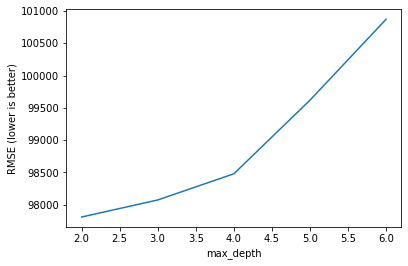

In [129]:
# plot max_depth (x-axis) versus RMSE (y-axis)
%matplotlib inline
plt.plot(max_depth_range, RMSE_scores)
plt.xlabel('max_depth')
plt.ylabel('RMSE (lower is better)')
plt.show()

As per the graph above, minimum RMSE is achieved with the max depth of 2 which may not be an optimum depth. However, as the depth increases, the RMSE also increases and after depth of 4, there is sharp increase in RMSE. Therefore, we can consider depth of 4 as our threshold depth for the DT model. 

In [141]:
model_1 = DecisionTreeRegressor(max_depth = 4, min_samples_leaf = 4, random_state = 1).fit(X_train, y_train)
# pd.DataFrame({'Feature':X_train.columns, 'Importance' : model_1.feature_importances_})

y_pred = model_1.predict(X_train)
pd.DataFrame(data = {'y_train':pd.Series(y_train).values, 'y_pred':pd.Series(y_pred)})

,y_train,y_pred
0,258935.0,66208.927093
1,15802.0,52458.706570
2,31340.0,52458.706570
3,19705.0,52458.706570
4,830.0,52458.706570
...,...,...
10495,12881.0,68962.922967
10496,132328.0,52458.706570
10497,9442.0,52458.706570
10498,8730.0,52458.706570


In [131]:
# comparing predicted values with actual ones in the train data
y_pred_test = model_1.predict(X_test)
pd.DataFrame(data = {'y_train':pd.Series(y_test).values, 'y_pred':pd.Series(y_pred_test)})

,y_train,y_pred
0,4874.0,61656.010434
1,5442.0,66208.927093
2,3222.0,52458.706570
3,307201.0,52458.706570
4,4878.0,52458.706570
...,...,...
4495,10141.0,395290.550000
4496,13510.0,52458.706570
4497,18473.0,52458.706570
4498,244068.0,52458.706570


In [132]:
mse_train = np.sqrt(mean_squared_error(y_train, y_pred))
mse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f'mse_train : {mse_train}  |  mse_test : {mse_test}')

mse_train : 96450.04418129317  |  mse_test : 98327.22383737109


The RMSE of tree_1 with max_depth of 3 is 97153 while model_1 with max_depth of 4 has RMSE of 96450. Therefore, there is slight improvement in the accuracy of model_1. Predicting the values for target data. 

### Predicting the credit card consumption for the target data using model_1. 

In [133]:
target_ML.isna().sum()
target_ML.dropna(inplace = True)
target_ML.shape

(4993, 42)

In [134]:
# replacing the region_code with the codes obtained while grouping region_code based on cc_cons in the main data

to_join = gpd_data[['region_code', 'Region_Code_Gp']].set_index('region_code')
target_ML = target_ML.join(to_join, on = 'region_code')
target_ML.Region_Code_Gp = target_ML.Region_Code_Gp.astype('category')
target_ML.drop('region_code', axis = 1, inplace = True)
print(target_ML.shape)
target_ML.head(10)

(4993, 42)


,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,cc_count_jun,dc_count_apr,dc_count_may,dc_count_jun,card_lim,investment_1,investment_2,investment_3,investment_4,debit_amount_apr,credit_amount_apr,debit_count_apr,credit_count_apr,max_credit_amount_apr,debit_amount_may,credit_amount_may,credit_count_may,debit_count_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,emi_active,account_type,gender,Income,Emp_Tenure_Years,Tenure_with_Bank,NetBanking_Flag,Avg_days_between_transaction,age_gps,Region_Code_Gp
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
17591,2795.45,1290.00,6141.05,676.50,9146.10,15479.00,4.0,10,4,47,56,6,125000,13.80,376600.50,1633.0,-5715.49023,27646.84,44341.00,16.0,36,24485.0,23512.67,41755.0,24,20,9750.0,30527.88,31271.00,3,12,25945.92,1170.49,current,M,MEDIUM,11.9,4,1,16.0,1,0
13541,29405.13,1640.00,1670.00,2463.92,10947.50,956.00,3.0,10,4,50,38,31,59000,101891.25,470000.00,891.0,35346.00000,32247.25,21946.00,42.0,5,3375.0,15049.44,130299.0,43,40,16967.0,14342.83,16582.00,6,39,12214.00,16447.45,current,M,MEDIUM,7.8,6,0,19.0,0,0
13431,5985.20,6189.00,2696.09,766.00,716.00,4133.22,7.0,30,5,24,27,2,49999,53374.97,674291.83,54101.0,2557.00000,63169.00,36616.50,41.0,6,14950.0,133659.00,40422.0,42,35,36398.0,32503.16,33539.54,5,9,13215.00,2622.28,current,M,LOW,33.0,10,1,15.0,3,0
8687,2105.93,18225.00,34763.56,167.00,4260.27,20185.00,1.0,99,71,5,1,11,520000,9118.35,470000.00,5905.0,5464.00000,39442.80,43173.38,46.0,1,235844.0,99686.03,48148.0,3,5,97825.0,93572.42,109429.75,21,0,72317.00,340.79,current,M,MEDIUM,7.8,5,1,7.0,0,0
14727,3269.00,3532.00,3158.40,2699.77,3373.48,5120.00,2.0,10,47,5,25,1,152000,12850544.36,101.24,130000.0,1332.00000,8937.00,15232.00,11.0,1,14495.0,190374.25,25926.0,70,75,27936.0,19011.50,41401.00,6,35,42344.00,2812.20,current,M,LOW,12.6,9,1,3.0,4,0
14988,11495.51,2701.00,3957.24,1395.00,36608.50,2296.00,2.0,23,35,21,62,13,276000,96218.53,1155000.00,54101.0,-5998.43994,81568.39,9418.00,5.0,6,22599.0,46739.30,80813.0,2,8,27906.0,23978.50,32248.75,9,63,24986.00,291.16,saving,M,LOW,8.0,7,1,12.0,0,0
14859,3837.39,10809.00,126467.15,6204.00,3947.37,6288.00,5.0,11,50,21,17,3,39000,1895.04,185097.60,15654.0,20324.00000,90521.16,109318.16,11.0,1,117591.0,16097.11,45735.0,2,20,11388.0,14789.48,33319.00,5,32,45228.00,4786.40,current,M,MEDIUM,9.1,2,0,12.0,0,0
16636,22928.50,6331.49,9974.84,2699.00,4578.00,704.00,531.0,1,74,7,3,12,393000,27316.50,78050.00,13873.0,5730.00000,46865.63,41599.00,69.0,19,124720.0,30674.96,15929.0,3,20,69056.0,25376.75,81303.01,22,58,39930.00,8186.99,current,M,LOW,37.5,3,1,14.0,1,0
7625,2698.00,727.00,5264.50,5528.00,11310.50,627.44,26.0,9,9,1,2,17,381000,272677.25,400000.00,3570.0,0.00000,36117.25,28601.00,77.0,33,57417.0,8299.00,36959.0,47,13,15700.0,22579.57,12317.00,6,12,63300.00,54632.60,saving,M,MEDIUM,11.9,4,1,2.0,1,0


In [135]:
num_data = target_ML.select_dtypes(['int', 'float'])
cat_data = target_ML.select_dtypes(['category', 'object'])

# clip upper and lower 1% of the data with 1st and 99th quantile
num_data.clip(lower = num_data.quantile(0.01), upper = num_data.quantile(.99), axis = 1, inplace = True)
num_data.apply(eda)

/Users/shamshersingh/opt/anaconda3/lib/python3.9/site-packages/pandas/core/generic.py:9032: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._where(cond, other, inplace, axis, level, errors=errors)
/Users/shamshersingh/opt/anaconda3/lib/python3.9/site-packages/pandas/core/generic.py:9032: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._where(cond, other, inplace, axis, level, errors=errors)


,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,cc_count_jun,dc_count_apr,dc_count_may,dc_count_jun,card_lim,investment_1,investment_2,investment_3,investment_4,debit_amount_apr,credit_amount_apr,debit_count_apr,credit_count_apr,max_credit_amount_apr,debit_amount_may,credit_amount_may,credit_count_may,debit_count_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,emi_active,Emp_Tenure_Years,Tenure_with_Bank,Avg_days_between_transaction
Total,4.993000e+03,4.993000e+03,4.993000e+03,4.993000e+03,4.993000e+03,4.993000e+03,4993.00000,4993.000000,4993.000000,4993.000000,4993.000000,4993.000000,4.993000e+03,4.993000e+03,4.993000e+03,4.993000e+03,4.993000e+03,4.993000e+03,4.993000e+03,4993.000000,4993.000000,4.993000e+03,4.993000e+03,4.993000e+03,4993.000000,4993.000000,4.993000e+03,4.993000e+03,4.993000e+03,4993.000000,4993.000000,4.993000e+03,4.993000e+03,4993.000000,4993.000000,4993.000000
TotalMissing,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
PercMissing,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
Mean,1.703573e+04,7.544092e+03,1.515017e+04,7.361932e+03,1.162797e+04,6.882882e+03,41.99279,31.072101,39.873623,16.645704,14.271380,31.054476,2.817308e+05,4.167643e+05,2.185158e+05,4.497037e+04,3.336095e+03,6.588534e+04,7.237313e+04,35.730823,11.069898,4.857796e+04,6.175668e+04,7.594720e+04,11.911276,40.922091,5.243993e+04,7.284809e+04,7.256781e+04,19.779491,44.177048,4.712282e+04,9.533380e+03,13.159223,5.452634,11.029241
Std,2.137551e+04,1.016462e+04,2.002820e+04,1.096604e+04,1.534124e+04,1.135773e+04,99.08832,30.708207,31.946223,18.649518,17.185471,29.560181,1.821644e+05,1.421410e+06,3.121895e+05,8.931882e+04,7.077102e+03,7.789041e+04,8.417474e+04,30.142730,12.395869,5.836098e+04,7.399394e+04,8.586686e+04,16.894550,40.638742,6.317937e+04,8.717281e+04,8.203563e+04,26.596885,34.995059,5.530042e+04,1.881799e+04,10.534990,2.884358,5.445713
Var,4.569125e+08,1.033194e+08,4.011289e+08,1.202540e+08,2.353536e+08,1.289980e+08,9818.49514,942.993999,1020.561149,347.804537,295.340401,873.804323,3.318387e+10,2.020407e+12,9.746228e+10,7.977852e+09,5.008537e+07,6.066915e+09,7.085387e+09,908.584180,153.657573,3.406004e+09,5.475103e+09,7.373118e+09,285.425820,1651.507350,3.991633e+09,7.599099e+09,6.729845e+09,707.394275,1224.654145,3.058136e+09,3.541168e+08,110.986017,8.319521,29.655795
Min,5.905000e+02,1.467600e+02,5.226800e+02,1.521000e+02,3.167600e+02,1.960000e+02,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.600000e+04,1.368400e+01,6.000000e+00,5.050000e+02,-1.217900e+04,1.890000e+02,4.590000e+02,1.000000,0.000000,5.070000e+02,1.195750e+03,3.847500e+02,0.000000,1.000000,1.109092e+02,1.057800e+03,2.980000e+02,1.000000,0.000000,1.600000e+02,3.152080e+01,0.900000,1.000000,2.000000
Lower_CutOff-IQR,-2.027324e+04,-1.013447e+04,-1.771979e+04,-8.642000e+03,-1.362769e+04,-7.254500e+03,-53.50000,-44.500000,-66.500000,-32.500000,-26.500000,-71.000000,-2.930000e+05,-2.235328e+05,-2.734820e+05,-6.789000e+04,-1.032750e+04,-6.141801e+04,-6.188600e+04,-50.500000,-23.500000,-2.797900e+04,-5.795528e+04,-7.958050e+04,-10.000000,-76.000000,-3.504250e+04,-6.652875e+04,-6.925118e+04,-21.500000,-79.500000,-3.404400e+04,-1.023372e+04,-

In [136]:
# converting the object type data to categorical data
cat_data.apply(lambda x : x.unique())

account_type                                       [current, saving]
gender                                                        [M, F]
Income                                           [MEDIUM, LOW, HIGH]
NetBanking_Flag                 [1, 0]
Categories (2, int64): [0, 1]
age_gps            [1, 0, 3, 4, 2]
Categories (5, int64): [0, 1, ...
Region_Code_Gp                  [0, 3]
Categories (2, int64): [0, 3]
dtype: object

In [137]:
cat_data['account_type'] = np.where(cat_data.account_type == 'current', 0, 1)
cat_data['gender'] = np.where(cat_data.gender == 'M', 0, 1)
cat_data['Income'] = cat_data['Income'].map({'LOW':0, 'MEDIUM':1, 'HIGH':2 })
target_ML = pd.concat([num_data, cat_data], axis = 1)
target_ML.head()

/var/folders/vt/5tvfbhvx4g74ydhsmm2p5bmw0000gn/T/ipykernel_9305/2971671487.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_data['account_type'] = np.where(cat_data.account_type == 'current', 0, 1)
/var/folders/vt/5tvfbhvx4g74ydhsmm2p5bmw0000gn/T/ipykernel_9305/2971671487.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_data['gender'] = np.where(cat_data.gender == 'M', 0, 1)
/var/folders/vt/5tvfbhvx4g74ydhsmm2p5bmw0000gn/T/ipykernel_9305/2971671487.py:3: SettingWithCopyWarning: 
A value is try

,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,cc_count_jun,dc_count_apr,dc_count_may,dc_count_jun,card_lim,investment_1,investment_2,investment_3,investment_4,debit_amount_apr,credit_amount_apr,debit_count_apr,credit_count_apr,max_credit_amount_apr,debit_amount_may,credit_amount_may,credit_count_may,debit_count_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,emi_active,Emp_Tenure_Years,Tenure_with_Bank,Avg_days_between_transaction,account_type,gender,Income,NetBanking_Flag,age_gps,Region_Code_Gp
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
17591,2795.45,1290.0,6141.05,676.50,9146.10,15479.00,4.0,10,4,47,56,6,125000,13.80,376600.50,1633.0,-5715.49023,27646.84,44341.00,16.0,36,24485.0,23512.67,41755.0,24,20,9750.0,30527.88,31271.00,3,12,25945.92,1170.49,11.9,4,16.0,0,0,1,1,1,0
13541,29405.13,1640.0,1670.00,2463.92,10947.50,956.00,3.0,10,4,50,38,31,59000,101891.25,470000.00,891.0,26601.00000,32247.25,21946.00,42.0,5,3375.0,15049.44,130299.0,43,40,16967.0,14342.83,16582.00,6,39,12214.00,16447.45,7.8,6,19.0,0,0,1,0,0,0
13431,5985.20,6189.0,2696.09,766.00,716.00,4133.22,7.0,30,5,24,27,2,49999,53374.97,674291.83,54101.0,2557.00000,63169.00,36616.50,41.0,6,14950.0,133659.00,40422.0,42,35,36398.0,32503.16,33539.54,5,9,13215.00,2622.28,33.0,10,15.0,0,0,0,1,3,0
8687,2105.93,18225.0,34763.56,167.00,4260.27,20185.00,1.0,99,71,5,1,11,520000,9118.35,470000.00,5905.0,5464.00000,39442.80,43173.38,46.0,1,235844.0,99686.03,48148.0,3,5,97825.0,93572.42,109429.75,21,0,72317.00,340.79,7.8,5,7.0,0,0,1,1,0,0
14727,3269.00,3532.0,3158.40,2699.77,3373.48,5120.00,2.0,10,47,5,25,1,152000,10535967.50,101.24,130000.0,1332.00000,8937.00,15232.00,11.0,1,14495.0,190374.25,25926.0,70,75,27936.0,19011.50,41401.00,6,35,42344.00,2812.20,12.6,9,3.0,0,0,0,1,4,0


In [138]:
y_target = model_1.predict(target_ML)
print(pd.Series(y_target))

0       59815.519205
1       59815.519205
2       59815.519205
3       59815.519205
4       59815.519205
            ...     
4988    59815.519205
4989    59815.519205
4990    59815.519205
4991    59815.519205
4992    59815.519205
Length: 4993, dtype: float64
[CV 3/10; 197/256] END max_depth=6, min_samples_leaf=2, min_samples_split=6;, score=-10037363717.026 total time=   0.2s
[CV 4/10; 197/256] START max_depth=6, min_samples_leaf=2, min_samples_split=6...
[CV 4/10; 197/256] END max_depth=6, min_samples_leaf=2, min_samples_split=6;, score=-9452102908.037 total time=   0.2s
[CV 1/10; 199/256] START max_depth=6, min_samples_leaf=2, min_samples_split=8...
[CV 1/10; 199/256] END max_depth=6, min_samples_leaf=2, min_samples_split=8;, score=-10487320062.633 total time=   0.2s
[CV 2/10; 199/256] START max_depth=6, min_samples_leaf=2, min_samples_split=8...
[CV 2/10; 199/256] END max_depth=6, min_samples_leaf=2, min_samples_split=8;, score=-10493605536.653 total time=   0.2s
[CV 7/10; 200/256]

[CV 1/10; 198/256] END max_depth=6, min_samples_leaf=2, min_samples_split=7;, score=-10487320062.633 total time=   0.2s
[CV 2/10; 198/256] START max_depth=6, min_samples_leaf=2, min_samples_split=7...
[CV 2/10; 198/256] END max_depth=6, min_samples_leaf=2, min_samples_split=7;, score=-10781328123.196 total time=   0.2s
[CV 1/10; 200/256] START max_depth=6, min_samples_leaf=2, min_samples_split=9...
[CV 1/10; 200/256] END max_depth=6, min_samples_leaf=2, min_samples_split=9;, score=-10279982383.673 total time=   0.2s
[CV 2/10; 200/256] START max_depth=6, min_samples_leaf=2, min_samples_split=9...
[CV 2/10; 200/256] END max_depth=6, min_samples_leaf=2, min_samples_split=9;, score=-10493605536.653 total time=   0.2s
[CV 7/10; 201/256] START max_depth=6, min_samples_leaf=3, min_samples_split=2...
[CV 7/10; 201/256] END max_depth=6, min_samples_leaf=3, min_samples_split=2;, score=-9846738174.623 total time=   0.2s
[CV 8/10; 201/256] START max_depth=6, min_samples_leaf=3, min_samples_split=2

[CV 7/10; 195/256] END max_depth=6, min_samples_leaf=2, min_samples_split=4;, score=-9825390331.417 total time=   0.2s
[CV 8/10; 195/256] START max_depth=6, min_samples_leaf=2, min_samples_split=4...
[CV 8/10; 195/256] END max_depth=6, min_samples_leaf=2, min_samples_split=4;, score=-9815827565.225 total time=   0.2s
[CV 5/10; 197/256] START max_depth=6, min_samples_leaf=2, min_samples_split=6...
[CV 5/10; 197/256] END max_depth=6, min_samples_leaf=2, min_samples_split=6;, score=-11050423871.223 total time=   0.2s
[CV 6/10; 197/256] START max_depth=6, min_samples_leaf=2, min_samples_split=6...
[CV 6/10; 197/256] END max_depth=6, min_samples_leaf=2, min_samples_split=6;, score=-10449057274.555 total time=   0.2s
[CV 9/10; 198/256] START max_depth=6, min_samples_leaf=2, min_samples_split=7...
[CV 9/10; 198/256] END max_depth=6, min_samples_leaf=2, min_samples_split=7;, score=-9930267933.620 total time=   0.2s
[CV 10/10; 198/256] START max_depth=6, min_samples_leaf=2, min_samples_split=7.

### Even DT Regressor is not working on this data.